<a href="https://colab.research.google.com/github/bartala/PalliativEtiological/blob/main/Palliativ_Etiological_Source_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup Instructions

Before executing the code, follow these steps for a smooth experience:

## I. Initial Setup and Preparation
- ### Selecting the Hardware Accelerator
  - Navigate to "Runtime" -> "Change runtime type" in the Colab menu.
  - Choose "GPU" as your hardware accelerator for optimal performance.

- ### Python Version Check
  - Execute `!python --version` in a new cell to confirm your Python version.
  - This notebook is optimized for Python 3.10.

- ### Accessing Necessary Files
  - All required files, including datasets and embeddings, are in our GitHub repository.
  - Download these files and upload them to your Google Drive in a structured directory, like "/content/drive/MyDrive/project/PalliativEtiological
/".

- ### Google Drive / Colab's local disk
  - Mount your Google Drive to access the files.
  - Alternatively, upload files to Colab's local disk.

- ### Run Code
  To run specific sections or the entire code efficiently, follow these guidelines:
  
  - **Initial Setup:**
    - Begin with the setup instructions to establish the necessary environment.
    - Make sure the paths for all required files are correctly set.

  - **Running Specific Sections (Sections 2-9):**
    - **File Dependencies:**
      - Check each section's instructions for its file requirements.
      - Ensure these files are loaded and their paths are correctly set.
    - **Independence of Sections:**
      - Sections can run independently, **except for section 7**, which needs the 10-fold CV SciBert. Confirm that all necessary files for each section are available.


  - **Running the Entire Notebook:**
    - Go to "Runtime" in the Colab menu and select "Run all".
    - **Key File Check:** Ensure `comprehensive_dataset.csv.gz` is available and loaded, as it's critical for the entire notebook.

  - **Source of Files:**
    - Download necessary files from our GitHub repository.
    - Store them correctly in your Google Drive or Colab's local disk.



## **II. Using Pre-generated Resources**
- ### Pre-generated Embeddings
  - Generating embeddings for the GNN model can be quite time-consuming.
  - To expedite the process, you may choose to use pre-generated embeddings from our GitHub repository.
  - Instructions for using these embeddings are provided in the relevant sections of this notebook.

- ### Pre-finetuned SciBERT Model
  - Finetuning the SciBERT model is also a resource-intensive task, requiring significant time.
  - As a convenient alternative, we offer a pre-finetuned SciBERT model available in our GitHub repository.
  - You can directly use this model, skipping the finetuning step. Details on how to do this are included in the notebook.
  - Please note: The pre-finetuned SciBERT model is specifically designed for generating embeddings for the GNN model. It is not intended for comparison with the GNN.

## **III. Comparing GNN Model and SciBERT**
- ### Fine-Tuning for Comparison
  - To effectively compare the performance between the GNN model and SciBERT, it's essential to fine-tune both using the 10-fold cross-validation process.
  - Detailed instructions for fine-tuning SciBERT using 10-fold cross-validation are provided in the respective sections of this notebook.

## **IV. Important Note on Model Fine-Tuning**
- ### Requirement for Self Fine-Tuning
  - Due to our use of 10-fold cross-validation (10CV) for model comparison, it's necessary for you to fine-tune the SciBERT model yourself, rather than using a single pre-finetuned model we provided in GitHub.
  - The 10CV process involves training and evaluating the model on different subsets of the data across 10 iterations, which cannot be replicated with a pre-finetuned model designed for a single dataset split.
  - This step ensures that each model is optimized and evaluated under similar conditions, allowing for a fair and meaningful comparison.
  - We provide detailed steps in the notebook for fine-tuning the SciBERT model using 10-fold cross-validation to facilitate this process.

- ### Why Not Use a Pre-Finetuned Model?
  - Using a single pre-finetuned model does not align with the 10CV methodology, as it would only reflect the model's performance on one specific training-validation split.
  - To maintain the integrity of the comparative analysis between the GNN model and SciBERT, each model must undergo the same 10-fold cross-validation process.


In [1]:
# check python version
!python --version

Python 3.10.12


## Mounting Google Drive and Specifying Paths for Dataset, Model, and Embeddings

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # Mounting Google Drive for File Access

Mounted at /content/drive


Specify filenames for the embeddings generated using SciBERT
Define the file paths for embeddings to be used as input in the GNN model.
Adjust the paths as per your directory structure.

In [3]:
comprehensive_dataset_path = '/content/drive/MyDrive/project/GNN/comprehensive_dataset.csv.gz'  # Replace with your dataset path before running

fine_tuned_scibert_path = './fine_tuned_scibert_model'  # Replace with path to your compressed fine-tuned model
compressed_model = f"{fine_tuned_scibert_path}.tar.gz" # Do not change.

drug_embeddings_file_path = 'drug_embeddings_SciBERT.pt'
disease_embeddings_file_path = 'disease_embeddings_SciBERT.pt'
gene_embeddings_file_path = 'gene_embeddings_SciBERT.pt'

gene_embeddings_pca_path = 'gene_features_pca.pt'  # Ensure this path points to your drug embeddings file
disease_embeddings_pca_path = 'disease_features_pca.pt'  # Ensure this path points to your disease embeddings file
drug_embeddings_pca_path = 'drug_features_pca.pt' # Ensure this path points to your gene embeddings file

## Installing Necessary Libraries


In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00


In [5]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=f063e7f7641b249231401a9a9bd66c43b85f20c9698379852e859462a406f584
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [6]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00


In [7]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.3 MB/s eta 0:00:00


## Importing Necessary Libraries

In [8]:
# Standard libraries
import os
import csv
import gc
import random
import pickle
import gzip
import shutil
from itertools import product
from collections import defaultdict, Counter
from tqdm import tqdm

# Scientific computing and data manipulation
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

# Machine Learning and Deep Learning frameworks
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Optimization algorithms from PyTorch
from torch.optim import Adam, SGD, AdamW, LBFGS, Adadelta, RMSprop
from torch.nn.utils import clip_grad_norm_
# PyTorch Geometric (PyG) for Graph Neural Networks (GNNs)
import torch_geometric
from torch_geometric.data import HeteroData
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import (GraphConv, GATConv, GCNConv, SAGEConv, GATv2Conv, Linear, HeteroConv, HGTConv, RGCNConv, RGATConv, MessagePassing, global_add_pool, Node2Vec)
import torch_geometric.transforms as T
from torch_geometric.explain import GNNExplainer
# scikit-learn
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_auc_score, auc, balanced_accuracy_score, precision_score, recall_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

# Plotting and visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D  # Import Line2D for edge legend
import networkx as nx
from IPython.display import Javascript  # Restrict height of output cell.

# NLP and transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, AutoModel
from datasets import Dataset, DatasetDict

Generate requirements.txt file

In [12]:
import pkg_resources
import platform

# List of third-party libraries
libraries = [
    'numpy', 'pandas', 'scipy', 'torch', 'torch-geometric',
    'scikit-learn', 'seaborn', 'matplotlib', 'networkx',
    'transformers', 'datasets'
]

# Get the current Python version
python_version = platform.python_version()

# File to write the requirements
with open('requirements.txt', 'w') as f:

    f.write(f"# Python version: {python_version}\n")

    for lib in libraries:
        try:
            version = pkg_resources.get_distribution(lib).version
            f.write(f"{lib}=={version}\n")
        except pkg_resources.DistributionNotFound:
            f.write(f"# {lib} not found\n")

 ## Loading the Dataset - Replace with your dataset path before running

In [9]:
# Load data sets that contain all the information we need for the graph.
df_all = pd.read_csv(comprehensive_dataset_path)

# Filter df that contain only drugs with e/p.
df = df_all[df_all['MoA'] != 'both']

# Reset the index of the DataFrame to ensure continuity after filtering rows.
df.reset_index(drop=True, inplace=True)

# 2. Preprocess The Dataset & Construct a Heterogeneous Network Using PyG

Setting Seed for Reproducibility

In [ ]:
def set_seed(seed_value=24):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)  # Sets the seed for generating random numbers for CPU operations in PyTorch.
    torch.cuda.manual_seed(seed_value)  # Sets the seed for generating random numbers on the current GPU in PyTorch.
    torch.cuda.manual_seed_all(seed_value)  # Sets the seed for generating random numbers on all GPUs in PyTorch.
    np.random.seed(seed_value)  # Sets the seed for generating random numbers in NumPy.
    torch.backends.cudnn.deterministic = True  # Ensures deterministic algorithm selection for Convolution operations.
    torch.backends.cudnn.benchmark = False  # Disables the inbuilt cuDNN auto-tuner to select the best algorithm for Convolution operations.

set_seed(24)  # Initialize the seed with a specific value (24) for reproducibility.


Constructing a Heterogeneous Network

In [ ]:
# 1. Create node mappings

# Drugs
unique_drugs = df.loc[df['Source Type'] == 'Drug', 'Source Name'].unique().tolist()
drug_mapping = {drug: i for i, drug in enumerate(unique_drugs)}

# Diseases
unique_diseases = df[df['Source Type'] == 'Disease']['Source Name'].unique().tolist()
disease_mapping = {disease: i for i, disease in enumerate(unique_diseases)}

# Genes (Include all genes)
genes_from_source = df[df['Source Type'] == 'Gene']['Source Name'].unique().tolist()
genes_from_target = df[df['Target Type'] == 'Gene']['Target Name'].unique().tolist()
all_genes = list(set(genes_from_source + genes_from_target))
gene_mapping = {gene: i for i, gene in enumerate(all_genes)}

# 2. Process node labels for drugs

# Extract unique drug information
drug_info_df = df[df['Source Type'] == 'Drug'].drop_duplicates(subset=['Source Name'])

# Convert MoA to labels
drug_info_df['MoA'] = drug_info_df['MoA'].apply(lambda x: 0 if x == 'p' else (1 if x == 'e' else x))

# Convert the 'MoA' column to a numpy array of type float32, then to a PyTorch tensor
drug_y = torch.tensor(drug_info_df['MoA'].values.astype(np.float32))

# Create a mask to identify which drugs have labels (MoA not equal to -1)
drug_mask = drug_y != -1

# 3. Create edge indices for the various interactions

# Drug-Gene interactions
drug_gene_edges_df = df[(df['Source Type'] == 'Drug') & (df['Target Type'] == 'Gene')]
source_nodes_dg = drug_gene_edges_df["Source Name"].map(drug_mapping).dropna().astype(int).values
target_nodes_dg = drug_gene_edges_df['Target Name'].map(gene_mapping).dropna().astype(int).values
edge_index_dg = torch.tensor(np.array([source_nodes_dg, target_nodes_dg]), dtype=torch.long)

# Disease-Gene interactions
disease_gene_edges_df = df[(df['Source Type'] == 'Disease') & (df['Target Type'] == 'Gene')]
source_nodes_pg = disease_gene_edges_df['Source Name'].map(disease_mapping).dropna().astype(int).values
target_nodes_pg = disease_gene_edges_df['Target Name'].map(gene_mapping).dropna().astype(int).values
edge_index_pg = torch.tensor(np.array([source_nodes_pg, target_nodes_pg]), dtype=torch.long)

# Gene-Gene interactions (PPI)
gene_gene_edges_df = df[(df['Source Type'] == 'Gene') & (df['Target Type'] == 'Gene')]
source_nodes_gg = gene_gene_edges_df['Source Name'].map(gene_mapping).dropna().astype(int).values
target_nodes_gg = gene_gene_edges_df['Target Name'].map(gene_mapping).dropna().astype(int).values
edge_index_gg = torch.tensor(np.array([source_nodes_gg, target_nodes_gg]), dtype=torch.long)


Setting Up Train-Validation and Test Splits

In [ ]:
# Calculate total number of nodes
num_nodes_drugs = len(unique_drugs)

# Split the drugs into training/validation and test sets
train_val_drugs, test_drugs = train_test_split(unique_drugs, test_size=0.1, random_state=24, stratify=drug_info_df['MoA'])

# Get the indices for training/validation and test drugs
train_val_indices = drug_info_df[drug_info_df['Source Name'].isin(train_val_drugs)].index
test_indices = drug_info_df[drug_info_df['Source Name'].isin(test_drugs)].index

train_val_labels = drug_info_df.loc[train_val_indices, 'MoA'].values
test_labels = drug_info_df.loc[test_indices, 'MoA'].values


# 3. Fine-Tuning SciBERT

In [ ]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)

# Initialize lists to store metrics
SciBERT_valid_fold_metrics = []
SciBERT_test_fold_metrics = []

# Initialize lists to store ROC data for each fold
fold_fprs = []
fold_tprs = []
fold_roc_aucs = []

# Initialize variables to track the best model
best_f_score = -1
best_model_fold = None

# Function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'roc_auc': roc_auc_score(labels, logits[:,1])

    }

# def compute_metrics(eval_preds):
#     logits, labels = eval_preds
#     predictions = np.argmax(logits, axis=-1)
#     return {
#         'precision': precision_score(labels, predictions),
#         'recall': recall_score(labels, predictions),
#         'f1': f1_score(labels, predictions),
#         'roc_auc': roc_auc_score(labels, predictions)

#     }

# Extract the "Drug_Description"
drug_info_df['text'] = drug_info_df['Drug_Description_New'].fillna('')

test_df = drug_info_df.iloc[test_indices] # Create the test df with the same 'test_indices' we used for the GNN.
train_val_df = drug_info_df.iloc[train_val_indices] # Create the train_valid df with the same 'test_indices' we used for the GNN.
train_val_df.rename(columns={'MoA': 'label'}, inplace=True)
test_df.rename(columns={'MoA': 'label'}, inplace=True)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

# Prepare the test dataset
test_dataset = Dataset.from_pandas(test_df).map(preprocess_function, batched=True)

<ipython-input-15-353b845556cc>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val_df.rename(columns={'MoA': 'label'}, inplace=True)
<ipython-input-15-353b845556cc>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns={'MoA': 'label'}, inplace=True)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Executing 10-Fold Cross-Validation for SciBERT Model on Drug Description Data

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

# 10-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(train_val_df, train_val_df['label'])):
    print(f"Training for fold {fold + 1}")

    # Splitting data into train and validation for current fold
    train_df = train_val_df.iloc[train_index]
    val_df = train_val_df.iloc[val_index]

    # Create datasets
    train_dataset = Dataset.from_pandas(train_df).map(preprocess_function, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(preprocess_function, batched=True)

    # Model and Training
    model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=2)
    training_args = TrainingArguments(
        output_dir=f'./model_output_fold_{fold}',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.001,
        evaluation_strategy="epoch"
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate on validation set
    valid_results = trainer.evaluate(val_dataset)
    SciBERT_valid_fold_metrics.append(valid_results)

    # Evaluate on test set
    test_results = trainer.evaluate(test_dataset)
    SciBERT_test_fold_metrics.append(test_results)

    # Get predictions and true labels
    predictions = trainer.predict(test_dataset)
    logits = predictions.predictions
    labels = predictions.label_ids

    # Compute ROC data
    fpr, tpr, _ = roc_curve(labels, logits[:, 1])
    roc_auc = auc(fpr, tpr)

    # Store ROC data
    fold_fprs.append(fpr)
    fold_tprs.append(tpr)
    fold_roc_aucs.append(roc_auc)

    # Check if this model is the best so far based on F-score
    current_f_score = valid_results['eval_f1']
    if current_f_score > best_f_score:
        best_f_score = current_f_score
        best_model_fold = fold

        # Save the model as the current best
        trainer.save_model(fine_tuned_scibert_path)

<IPython.core.display.Javascript object>

Training for fold 1


Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.295682,0.813725,0.976471,0.887701,0.964706
2,No log,0.304382,0.870968,0.952941,0.910112,0.969489
3,No log,0.305071,0.897727,0.929412,0.913295,0.969748


Training for fold 2


Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.373203,0.747573,0.905882,0.819149,0.934066
2,No log,0.341338,0.808511,0.894118,0.849162,0.956173
3,No log,0.426384,0.808511,0.894118,0.849162,0.954363


Training for fold 3


Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.293167,0.869048,0.858824,0.863905,0.947712
2,No log,0.300397,0.895349,0.905882,0.900585,0.945882
3,No log,0.349408,0.869565,0.941176,0.903955,0.947059


Training for fold 4


Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.252872,0.879121,0.941176,0.909091,0.964314
2,No log,0.270569,0.843750,0.952941,0.895028,0.974118
3,No log,0.302123,0.890110,0.952941,0.920455,0.969804


Training for fold 5


Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.240708,0.915663,0.894118,0.904762,0.964183
2,No log,0.252649,0.908046,0.929412,0.918605,0.969150
3,No log,0.292811,0.919540,0.941176,0.930233,0.967451


Training for fold 6


Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.367866,0.848837,0.858824,0.853801,0.919477
2,No log,0.330938,0.866667,0.917647,0.891429,0.942876
3,No log,0.387515,0.875000,0.905882,0.890173,0.945621


Training for fold 7


Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.377311,0.763636,0.988235,0.861538,0.958562
2,No log,0.235105,0.883721,0.894118,0.888889,0.971503
3,No log,0.209897,0.883721,0.894118,0.888889,0.978039


Training for fold 8


Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.303793,0.862069,0.882353,0.872093,0.945229
2,No log,0.278368,0.869565,0.941176,0.903955,0.958170
3,No log,0.327157,0.876404,0.917647,0.896552,0.958431


Training for fold 9


Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.290315,0.860215,0.941176,0.898876,0.947059
2,No log,0.290402,0.904762,0.894118,0.899408,0.961961
3,No log,0.318334,0.895349,0.905882,0.900585,0.959869


Training for fold 10


Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,No log,0.348017,0.777778,0.988235,0.870466,0.953333
2,No log,0.300325,0.902439,0.870588,0.886228,0.963399
3,No log,0.321842,0.876404,0.917647,0.896552,0.967712


Compress and save the finetuned model

In [ ]:
# Compress the saved model folder
shutil.make_archive(fine_tuned_scibert_path, 'gztar', fine_tuned_scibert_path)

# Dictionary to store ROC data for each fold
roc_data = {
    'fold_fprs': fold_fprs,
    'fold_tprs': fold_tprs,
    'fold_roc_aucs': fold_roc_aucs
}

# Combine ROC data and SciBERT metrics into one dictionary
all_data = {
    'roc_data': roc_data,
    'SciBERT_valid_fold_metrics': SciBERT_valid_fold_metrics,
    'SciBERT_test_fold_metrics': SciBERT_test_fold_metrics
}

# Save the combined data to a file
with open('SciBERT_metrics.pkl', 'wb') as f:
    pickle.dump(all_data, f)

## Evaluate SciBERT

Load metricses from the file generate the evalution

In [ ]:
# Load the combined data from a file
with open('SciBERT_metrics.pkl', 'rb') as f:
    combined_data_loaded = pickle.load(f)

# Extract individual parts of the data
roc_data_loaded = combined_data_loaded['roc_data']
SciBERT_valid_metrics_loaded = combined_data_loaded['SciBERT_valid_fold_metrics']
SciBERT_test_metrics_loaded = combined_data_loaded['SciBERT_test_fold_metrics']


Displaying Validation and Test Metrics for Each Fold in SciBERT Cross-Validation

In [ ]:
# Print metrics for each fold for validation set
print("Validation Metrics for each fold:")
for i, metrics in enumerate(SciBERT_valid_metrics_loaded, 1):
    print(f'Fold {i}:', ', '.join([f'{key}: {value:.4f}' for key, value in metrics.items()]))

# Print metrics for each fold for test set
print("\nTest Metrics for each fold:")
for i, metrics in enumerate(SciBERT_test_metrics_loaded, 1):
    print(f'Fold {i}:', ', '.join([f'{key}: {value:.4f}' for key, value in metrics.items()]))

Validation Metrics for each fold:
Fold 1: eval_loss: 0.3051, eval_precision: 0.8977, eval_recall: 0.9294, eval_f1: 0.9133, eval_roc_auc: 0.9697, eval_runtime: 1.7817, eval_samples_per_second: 98.7820, eval_steps_per_second: 6.1740, epoch: 3.0000
Fold 2: eval_loss: 0.4264, eval_precision: 0.8085, eval_recall: 0.8941, eval_f1: 0.8492, eval_roc_auc: 0.9544, eval_runtime: 1.7201, eval_samples_per_second: 102.3210, eval_steps_per_second: 6.3950, epoch: 3.0000
Fold 3: eval_loss: 0.3494, eval_precision: 0.8696, eval_recall: 0.9412, eval_f1: 0.9040, eval_roc_auc: 0.9471, eval_runtime: 1.9332, eval_samples_per_second: 90.5230, eval_steps_per_second: 5.6900, epoch: 3.0000
Fold 4: eval_loss: 0.3021, eval_precision: 0.8901, eval_recall: 0.9529, eval_f1: 0.9205, eval_roc_auc: 0.9698, eval_runtime: 1.8491, eval_samples_per_second: 94.6410, eval_steps_per_second: 5.9490, epoch: 3.0000
Fold 5: eval_loss: 0.2928, eval_precision: 0.9195, eval_recall: 0.9412, eval_f1: 0.9302, eval_roc_auc: 0.9675, eval_r

Analyzing Overall Performance: Computing Average and Standard Deviation of SciBERT Metrics Across Folds

In [ ]:
# Calculate and print average and standard deviation of metrics across folds for both validation and test sets
for dataset_name, fold_metrics in [('Validation', SciBERT_valid_metrics_loaded), ('Test', SciBERT_test_metrics_loaded)]:
    average_metrics = {metric: np.mean([fm[metric] for fm in fold_metrics]) for metric in fold_metrics[0]}
    std_metrics = {metric: np.std([fm[metric] for fm in fold_metrics]) for metric in fold_metrics[0]}
    print(f"\nAverage {dataset_name} Metrics Across All Folds:")
    for metric, avg in average_metrics.items():
        print(f'Average {metric}: {avg:.4f}')
    print(f"\nStandard Deviation of {dataset_name} Metrics Across All Folds:")
    for metric, std in std_metrics.items():
        print(f'Std {metric}: {std:.4f}')


Average Validation Metrics Across All Folds:
Average eval_loss: 0.3241
Average eval_precision: 0.8792
Average eval_recall: 0.9200
Average eval_f1: 0.8990
Average eval_roc_auc: 0.9618
Average eval_runtime: 1.8271
Average eval_samples_per_second: 96.0666
Average eval_steps_per_second: 6.0313
Average epoch: 3.0000

Standard Deviation of Validation Metrics Across All Folds:
Std eval_loss: 0.0548
Std eval_precision: 0.0274
Std eval_recall: 0.0195
Std eval_f1: 0.0208
Std eval_roc_auc: 0.0100
Std eval_runtime: 0.0781
Std eval_samples_per_second: 4.1399
Std eval_steps_per_second: 0.2526
Std epoch: 0.0000

Average Test Metrics Across All Folds:
Average eval_loss: 0.3191
Average eval_precision: 0.8635
Average eval_recall: 0.9453
Average eval_f1: 0.9025
Average eval_roc_auc: 0.9646
Average eval_runtime: 2.0703
Average eval_samples_per_second: 94.2187
Average eval_steps_per_second: 6.2812
Average epoch: 3.0000

Standard Deviation of Test Metrics Across All Folds:
Std eval_loss: 0.0262
Std eval_pr

In [ ]:
# Clear the CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Explicitly invoke garbage collection
gc.collect()

29133

# 4. Embedding

In [ ]:
# Decompress the model
shutil.unpack_archive(compressed_model, fine_tuned_scibert_path)

# Load the tokenizer and the decompressed model
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
scibert_model = AutoModel.from_pretrained(fine_tuned_scibert_path)

# If GPU is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scibert_model.to(device)

def extract_embeddings(sentences):
    tokens = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
    tokens = tokens.to(device)
    with torch.no_grad():
        outputs = scibert_model(**tokens)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu()

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Generate embedding for drugs nodes

In [ ]:
# Initialize lists to store embeddings
drug_embeddings = []

for drug_description in tqdm(drug_info_df['Drug_Description_New']):
    embedding = extract_embeddings(drug_description)
    drug_embeddings.append(embedding)

description_embeddings_tensor = torch.cat(drug_embeddings, dim=0)

# Concatenate the two sets of embeddings to create a richer feature set
final_embeddings_tensor = description_embeddings_tensor
# Save the tensor
torch.save(final_embeddings_tensor, drug_embeddings_file_path)

100%|██████████| 1947/1947 [00:26<00:00, 74.01it/s]


Generate embedding for genes nodes

In [ ]:
gene_embeddings = []

# Generate gene embeddings
for gene in tqdm(all_genes):
    embedding = extract_embeddings(gene)
    gene_embeddings.append(embedding)

# Convert list of tensors to a single tensor
gene_embeddings_tensor = torch.cat(gene_embeddings, dim=0)

# Save the tensor
torch.save(gene_embeddings_tensor, gene_embeddings_file_path)


100%|██████████| 31459/31459 [05:47<00:00, 90.61it/s]


Generate embedding for diseases nodes

In [ ]:
disease_embeddings = []

# Generate disease embeddings
for disease in tqdm(unique_diseases):
    embedding = extract_embeddings(disease)
    disease_embeddings.append(embedding)

# Convert list of tensors to a single tensor
disease_embeddings_tensor = torch.cat(disease_embeddings, dim=0)

# Save the tensor
torch.save(disease_embeddings_tensor, disease_embeddings_file_path)

100%|██████████| 8156/8156 [01:30<00:00, 89.88it/s]


Reducing Embedding Dimensions Using PCA

In [ ]:
# Define the original and reduced embedding dimensions
original_embedding_dim = 768
reduced_embedding_dim = 128

# Function to apply PCA and reduce dimensionality
def apply_pca(embeddings, n_components):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

# Load the pre-trained embeddings
gene_embeddings = torch.load(gene_embeddings_file_path)
disease_embeddings = torch.load(disease_embeddings_file_path)
drug_embeddings = torch.load(drug_embeddings_file_path)

# Applying PCA to reduce the dimensionality of embeddings
gene_embeddings_reduced = apply_pca(gene_embeddings, reduced_embedding_dim)
disease_embeddings_reduced = apply_pca(disease_embeddings, reduced_embedding_dim)
drug_embeddings_reduced = apply_pca(drug_embeddings, reduced_embedding_dim)

# Updating the graph with reduced embeddings
gene_features_pca = torch.tensor(gene_embeddings_reduced, dtype=torch.float32)
disease_features_pca = torch.tensor(disease_embeddings_reduced, dtype=torch.float32)
drug_features_pca = torch.tensor(drug_embeddings_reduced, dtype=torch.float32)

# Save the PCA reduced features to files
torch.save(gene_features_pca, gene_embeddings_pca_path)
torch.save(disease_features_pca, disease_embeddings_pca_path)
torch.save(drug_features_pca, drug_embeddings_pca_path)

# 5. HeteroSciGNN

Initializing a Heterogeneous Graph with Pre-trained Embeddings

In [ ]:
transform = T.Compose([T.ToUndirected()])

# Function to rebuild the graph
def rebuild_graph(df, drug_mapping, gene_mapping, disease_mapping, drug_y):
    data = HeteroData() # Create the HeteroData object will be used to store the heterogeneous graph

    # Load the pre-trained embeddings
    gene_features = torch.load(gene_embeddings_pca_path)
    disease_features = torch.load(disease_embeddings_pca_path)
    drug_features = torch.load(drug_embeddings_pca_path)

    data['gene'].x = gene_features # Set gene features
    data['disease'].x = disease_features # Set disease features
    data['drug'].x = drug_features # Set drug features

    data['gene'].num_nodes = len(gene_mapping)
    data['drug'].num_nodes = len(drug_mapping)
    data['disease'].num_nodes = len(disease_mapping)

    data['drug'].y = drug_y # Set drug labels.
    data['drug', 'drug_target', 'gene'].edge_index = edge_index_dg # Set drug-gene edges
    data['disease', 'disease_gene', 'gene'].edge_index = edge_index_pg # Set phenotype-gene edges
    data['gene', 'PPI', 'gene'].edge_index = edge_index_gg # Set gene-gene edges

    data = transform(data) # Set reverse edges.
    data.validate(raise_on_error=True)  # Check the graph structure
    return data


Displaying the Structure of the Heterogeneous Graph

In [ ]:
print(rebuild_graph(df, drug_mapping, gene_mapping, disease_mapping, drug_y))

HeteroData(
  gene={
    x=[31459, 128],
    num_nodes=31459,
  },
  disease={
    x=[8156, 128],
    num_nodes=8156,
  },
  drug={
    x=[1947, 128],
    num_nodes=1947,
    y=[1947],
  },
  (drug, drug_target, gene)={ edge_index=[2, 10104] },
  (disease, disease_gene, gene)={ edge_index=[2, 27739] },
  (gene, PPI, gene)={ edge_index=[2, 1429954] },
  (gene, rev_drug_target, drug)={ edge_index=[2, 10104] },
  (gene, rev_disease_gene, disease)={ edge_index=[2, 27739] }
)


Defining the HeteroSciGNN Model Architecture

In [ ]:
class HeteroSciGNN(torch.nn.Module):
    def __init__(self):
        super(HeteroSciGNN, self).__init__()
        # in_channels parameter specifies the dimensionality of the input features of the source nodes.
        input_dim = 128
        layer1_output_dim = 512
        model_output_dim = 1

        # First layer with SAGEConv.
        self.layer1 = HeteroConv({
            ('drug', 'drug_target', 'gene'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False),
            ('disease', 'disease_gene', 'gene'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False),
            ('gene', 'PPI', 'gene'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False),
            ('gene', 'rev_drug_target', 'drug'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False),
            ('gene', 'rev_disease_gene', 'disease'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False)
        })

        # Second layer with SAGEConv.
        self.layer2 = HeteroConv({
            ('drug', 'drug_target', 'gene'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False),
            ('disease', 'disease_gene', 'gene'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False),
            ('gene', 'PPI', 'gene'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False),
            ('gene', 'rev_drug_target', 'drug'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False),
            ('gene', 'rev_disease_gene', 'disease'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False)
        })

        self.sigmoid = torch.nn.Sigmoid() # Sigmoid activation for binary classification [0, 1].
        self.relu = torch.nn.ReLU() # Non linear activation function.

        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x_dict, edge_index_dict, return_intermediate=False):
        """
        x_dict -  A dictionary where keys are node types (e.g., 'drug', 'gene', 'disease') and values are node feature tensors.
        edge_index_dict - A dictionary where keys are edge relations (e.g., ('drug', 'drug_target', 'gene'))
                            and values are edge index tensors indicating source and destination nodes for each edge.
        """

        # First layer with dropout
        x_dict = self.layer1(x_dict, edge_index_dict)
        for key in x_dict:
            x_dict[key] = self.dropout(self.relu(x_dict[key]))


        if return_intermediate: # Used for T-SNE
            # x_dict = self.layerTSNE(x_dict, edge_index_dict)
            return x_dict['drug']


        # Second layer with dropout
        x_dict = self.layer2(x_dict, edge_index_dict)


        # Directly use the output from layer2
        out = self.sigmoid(x_dict['drug'])

        return out

Train and Test functions

In [ ]:
def train(x_dict, edge_index_dict):
    # sets the model to training mode.
    model.train().to(device)
    # Before a new forward and backward pass, we need to ensures that gradients from the previous iterations don't accumulate.
    optimizer.zero_grad()
    # Performs a forward pass through the model.
    out = model(x_dict, edge_index_dict)

    # Flatten the output and labels for BCELoss
    out = out[data['drug'].train_mask].squeeze()
    labels = data['drug'].y[data['drug'].train_mask].type_as(out)

    criterion = torch.nn.BCELoss()
    loss = criterion(out, labels)

    loss.backward() # computes the gradients of the loss with respect to the model parameters. It's the step where backpropagation happens.
    clip_grad_norm_(model.parameters(), max_norm=0.5)
    optimizer.step() # updates the model's parameters based on the computed gradients.

    # Balanced Accuracy Calculation
    y_true_train = labels.cpu().detach().numpy()
    y_pred_train = (out.cpu().detach().numpy() > 0.5).astype(int) # Threshold to get 0 or 1 as class labels

    acc_train = balanced_accuracy_score(y_true_train, y_pred_train)
    return float(loss), acc_train

@torch.no_grad()
def evaluate(x_dict, edge_index_dict, mask_type='valid'):
    model.eval().to(device)
    out = model(x_dict, edge_index_dict)

    # Choose the correct mask based on the function call
    if mask_type == 'valid':
        mask = data['drug'].val_mask
    elif mask_type == 'test':
        mask = data['drug'].test_mask
    else:
        raise ValueError("Invalid mask type specified")

    labels = data['drug'].y[mask].type_as(out)
    y_true = labels.cpu().detach().numpy()
    y_true = y_true.astype('int32')

    masked_out = out[mask]
    y_pred_prob = masked_out.cpu().detach().numpy().flatten()

    y_pred = (y_pred_prob > 0.5).astype(int)
    y_pred = y_pred.flatten()

    # Compute metrics
    f_score = f1_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    correct = y_pred == y_true
    acc = correct.sum() / len(y_true)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

    print("Evaluation Results:")
    print(f"ROC AUC Score: {roc_auc}")
    print(f"Balance Accuracy = {balanced_acc}")

    return acc, recall, precision, f_score, roc_auc, fpr, tpr

Setting Up Stratified K-Fold Cross-Validation and Metrics Initialization for GNN Model

In [ ]:
# Initialize Stratified K-Fold for the cross-validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

# Initialize a list to hold metrics for each fold
GNN_valid_fold_metrics = []
GNN_test_fold_metrics = []
GNN_all_fprs = []
GNN_all_tprs = []
GNN_all_aucs = []
mean_fpr = np.linspace(0, 1, 100)  # Common set of FPRs for interpolation
GNN_fold_fprs, GNN_fold_tprs, GNN_fold_aucs = [], [], []

# Initialize dictionary to store metrics
metrics = {
    'loss': [],
    'acc_train': [],
    'acc_test': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'auc': []
}

Executing the Heterogeneous GNN Model in a Stratified K-Fold Cross-Validation Framework

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

best_f_score = 0.0

# Perform stratified K-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_indices, train_val_labels)):

    # Rebuild the graph for the current fold
    data = rebuild_graph(df, drug_mapping, gene_mapping, disease_mapping, drug_y)
    model = HeteroSciGNN()

    # The Adam optimizer is initialized with a learning rate.
    optimizer = Adam(model.parameters(), lr=0.0006)

    print(torch.cuda.is_available())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Determine whether a GPU is available for computation.
    data = data.to(device)
    model = model.to(device) # Move the model to the available device (either GPU or CPU).

    # Create masks for the current fold
    train_mask = torch.zeros(num_nodes_drugs, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes_drugs, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes_drugs, dtype=torch.bool)

    test_mask[test_indices] = True
    train_mask[train_idx] = True
    val_mask[val_idx] = True

    # Update the data object with train, validation, and test masks for drug nodes
    data['drug'].train_mask = train_mask
    data['drug'].val_mask = val_mask
    data['drug'].test_mask = test_mask

    # Train and validate the model using the current fold
    for epoch in range(1, 31):
        loss, acc_train = train(data.x_dict, data.edge_index_dict)
        acc_v, recall_v, precision_v, f1_v, roc_auc_v, fpr_v, tpr_v = evaluate(data.x_dict, data.edge_index_dict, mask_type='valid')
        print(f'Fold: {fold}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc_train: {acc_train:.4f}, Acc_valid: {acc_v:.4f}, F1-Score_valid: {f1_v:.4f}, Roc-Auc_valid: {roc_auc_v:.4f}')

    # Save metrics for the validtion set current fold.
    current_fold_metrics_valid = {
        'acc_v' : acc_v,
        'recall_v' : recall_v,
        'precision_v' : precision_v,
        'f1_v' : f1_v,
        'roc_auc_v' : roc_auc_v
    }
    GNN_valid_fold_metrics.append(current_fold_metrics_valid)

    acc_t, recall_t, precision_t, f1_t, auc_roc_t, fpr_t, tpr_t = evaluate(data.x_dict, data.edge_index_dict, mask_type='test')

    # Instead of interpolating, directly save the values
    GNN_fold_fprs.append(fpr_t)
    GNN_fold_tprs.append(tpr_t)
    GNN_fold_aucs.append(auc_roc_t)

    # Interpolate the TPRs for the common set of FPRs
    tprs_interpolated = np.interp(mean_fpr, fpr_t, tpr_t)
    tprs_interpolated[0] = 0.0  # Ensure it starts at 0

    # Save metrics and FPR, TPR for the test set of the current fold
    GNN_all_fprs.append(fpr_t)
    GNN_all_tprs.append(tprs_interpolated)
    GNN_all_aucs.append(auc_roc_t)

    # Save metrics for the test set current fold.
    current_fold_metrics_test = {
        'acc_t' : acc_t,
        'recall_t' : recall_t,
        'precision_t' : precision_t,
        'f1_t' : f1_t,
        'roc_auc_t' : auc_roc_t
    }
    GNN_test_fold_metrics.append(current_fold_metrics_test)


    print(f'### TEST RESULTS ###')
    print(f'Acc_test: {acc_t:.4f}, Recall: {recall_t:.4f}, Precision: {precision_t:.4f}, F1: {f1_t:.4f}, AUC: {auc_roc_t:.4f}')

    if f1_v > best_f_score:
        best_f_score = f1_v
        best_data = data
        torch.save(model.state_dict(), 'HeteroSciGNN.pth')
        torch.save(data, 'hetero_data.pt')


<IPython.core.display.Javascript object>

True
Evaluation Results:
ROC AUC Score: 0.6680961663417804
Balance Accuracy = 0.6163092917478882
Fold: 0, Epoch: 001, Loss: 0.8201, Acc_train: 0.3832, Acc_valid: 0.5966, F1-Score_valid: 0.4965, Roc-Auc_valid: 0.6681
Evaluation Results:
ROC AUC Score: 0.8757634827810267
Balance Accuracy = 0.723391812865497
Fold: 0, Epoch: 002, Loss: 0.6761, Acc_train: 0.5718, Acc_valid: 0.7102, F1-Score_valid: 0.6752, Roc-Auc_valid: 0.8758
Evaluation Results:
ROC AUC Score: 0.9179987004548409
Balance Accuracy = 0.8462638076673163
Fold: 0, Epoch: 003, Loss: 0.5808, Acc_train: 0.7164, Acc_valid: 0.8409, F1-Score_valid: 0.8409, Roc-Auc_valid: 0.9180
Evaluation Results:
ROC AUC Score: 0.9286549707602338
Balance Accuracy = 0.854970760233918
Fold: 0, Epoch: 004, Loss: 0.4865, Acc_train: 0.8075, Acc_valid: 0.8523, F1-Score_valid: 0.8571, Roc-Auc_valid: 0.9287
Evaluation Results:
ROC AUC Score: 0.9346328784925275
Balance Accuracy = 0.8698505523066926
Fold: 0, Epoch: 005, Loss: 0.4211, Acc_train: 0.8682, Acc_val

Save results

In [ ]:
# Save validation fold metrics
with open('GNN_valid_fold_metrics.pkl', 'wb') as f:
    pickle.dump(GNN_valid_fold_metrics, f)

# Save test fold metrics
with open('GNN_test_fold_metrics.pkl', 'wb') as f:
    pickle.dump(GNN_test_fold_metrics, f)

Load results metrics

In [ ]:
# Load validation fold metrics
with open('GNN_valid_fold_metrics.pkl', 'rb') as f:
    GNN_valid_metrics_loaded = pickle.load(f)

# Load test fold metrics
with open('GNN_test_fold_metrics.pkl', 'rb') as f:
    GNN_test_metrics_loaded = pickle.load(f)

Summarizing Validation Metrics and Variability Across K-Fold Cross-Validation in GNN Analysis

In [ ]:
# After the loop, print metrics for each fold
print("Metrics for each fold:")
for i, metrics in enumerate(GNN_valid_metrics_loaded, 1):
    print(f'Fold {i}:', ', '.join([f'{key}: {value:.4f}' for key, value in metrics.items()]))

# Calculate the average and standard deviation of metrics
average_metrics = {metric: np.mean([fm[metric] for fm in GNN_valid_metrics_loaded]) for metric in GNN_valid_metrics_loaded[0]}
std_metrics = {metric: np.std([fm[metric] for fm in GNN_valid_metrics_loaded]) for metric in GNN_valid_metrics_loaded[0]}

# Print the average results
print("\nAverage validation metrics across all folds:")
for metric, average_value in average_metrics.items():
    print(f'Average {metric}: {average_value:.4f}')

# Print the standard deviation of metrics
print("\nStandard deviation of validation metrics across all folds:")
for metric, std_value in std_metrics.items():
    print(f'Std {metric}: {std_value:.4f}')

Metrics for each fold:
Fold 1: acc_v: 0.8977, recall_v: 0.8842, precision_v: 0.9231, f1_v: 0.9032, roc_auc_v: 0.9582
Fold 2: acc_v: 0.9375, recall_v: 0.9655, precision_v: 0.9130, f1_v: 0.9385, roc_auc_v: 0.9757
Fold 3: acc_v: 0.9429, recall_v: 0.9487, precision_v: 0.9250, f1_v: 0.9367, roc_auc_v: 0.9894
Fold 4: acc_v: 0.9429, recall_v: 0.9620, precision_v: 0.9157, f1_v: 0.9383, roc_auc_v: 0.9883
Fold 5: acc_v: 0.9200, recall_v: 0.9136, precision_v: 0.9136, f1_v: 0.9136, roc_auc_v: 0.9639
Fold 6: acc_v: 0.9543, recall_v: 0.9595, precision_v: 0.9342, f1_v: 0.9467, roc_auc_v: 0.9823
Fold 7: acc_v: 0.9600, recall_v: 0.9556, precision_v: 0.9663, f1_v: 0.9609, roc_auc_v: 0.9927
Fold 8: acc_v: 0.9200, recall_v: 0.9405, precision_v: 0.8977, f1_v: 0.9186, roc_auc_v: 0.9753
Fold 9: acc_v: 0.9714, recall_v: 0.9756, precision_v: 0.9639, f1_v: 0.9697, roc_auc_v: 0.9886
Fold 10: acc_v: 0.9257, recall_v: 0.9639, precision_v: 0.8889, f1_v: 0.9249, roc_auc_v: 0.9770

Average validation metrics across a

Summarizing Test Metrics and Variability Across K-Fold Cross-Validation in GNN Analysis

In [ ]:
# After the loop, print metrics for each fold
print("Metrics for each fold:")
for i, metrics in enumerate(GNN_test_metrics_loaded, 1):
    print(f'Fold {i}:', ', '.join([f'{key}: {value:.4f}' for key, value in metrics.items()]))

# Calculate the average and standard deviation of metrics
average_metrics = {metric: np.mean([fm[metric] for fm in GNN_test_metrics_loaded]) for metric in GNN_test_metrics_loaded[0]}
std_metrics = {metric: np.std([fm[metric] for fm in GNN_test_metrics_loaded]) for metric in GNN_test_metrics_loaded[0]}

# Print the average results
print("\nAverage test metrics across all folds:")
for metric, average_value in average_metrics.items():
    print(f'Average {metric}: {average_value:.4f}')

# Print the standard deviation of metrics
print("\nStandard deviation of test metrics across all folds:")
for metric, std_value in std_metrics.items():
    print(f'Std {metric}: {std_value:.4f}')

Metrics for each fold:
Fold 1: acc_t: 0.9436, recall_t: 0.9684, precision_t: 0.9200, f1_t: 0.9436, roc_auc_t: 0.9817
Fold 2: acc_t: 0.9487, recall_t: 0.9684, precision_t: 0.9293, f1_t: 0.9485, roc_auc_t: 0.9763
Fold 3: acc_t: 0.9538, recall_t: 0.9684, precision_t: 0.9388, f1_t: 0.9534, roc_auc_t: 0.9849
Fold 4: acc_t: 0.9538, recall_t: 0.9684, precision_t: 0.9388, f1_t: 0.9534, roc_auc_t: 0.9839
Fold 5: acc_t: 0.9436, recall_t: 0.9684, precision_t: 0.9200, f1_t: 0.9436, roc_auc_t: 0.9717
Fold 6: acc_t: 0.9487, recall_t: 0.9684, precision_t: 0.9293, f1_t: 0.9485, roc_auc_t: 0.9803
Fold 7: acc_t: 0.9385, recall_t: 0.9579, precision_t: 0.9192, f1_t: 0.9381, roc_auc_t: 0.9856
Fold 8: acc_t: 0.9487, recall_t: 0.9789, precision_t: 0.9208, f1_t: 0.9490, roc_auc_t: 0.9864
Fold 9: acc_t: 0.9538, recall_t: 0.9789, precision_t: 0.9300, f1_t: 0.9538, roc_auc_t: 0.9844
Fold 10: acc_t: 0.9436, recall_t: 0.9789, precision_t: 0.9118, f1_t: 0.9442, roc_auc_t: 0.9757

Average test metrics across all fol

In [ ]:
# Clear the CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Explicitly invoke garbage collection
gc.collect()

4504

# 6. Base GNN

Generate embedding for the base model gnn, <br> Generate EigenVector

In [ ]:
# Calculating the total number of nodes in the graph
total_nodes = len(drug_mapping) + len(disease_mapping) + len(gene_mapping)
combined_adj_matrix = torch.zeros((total_nodes, total_nodes))

# Adding Drug-Gene edges
for src, tgt in tqdm(zip(source_nodes_dg, target_nodes_dg), total=len(source_nodes_dg), desc="Adding Drug-Gene Edges"):
    # Since drug nodes come first, their indices are unchanged
    # Gene indices need to be offset by the number of drug and phenotype nodes
    combined_adj_matrix[src, len(drug_mapping) + len(disease_mapping) + tgt] = 1
    combined_adj_matrix[len(drug_mapping) + len(disease_mapping) + tgt, src] = 1

# Adding Phenotype-Gene edges
for src, tgt in tqdm(zip(source_nodes_pg, target_nodes_pg), total=len(source_nodes_pg), desc="Adding Phenotype-Gene Edges"):
    # Offset source index for phenotypes by the number of drugs
    # Offset target index for genes as before
    combined_adj_matrix[len(drug_mapping) + src, len(drug_mapping) + len(disease_mapping) + tgt] = 1
    combined_adj_matrix[len(drug_mapping) + len(disease_mapping) + tgt, len(drug_mapping) + src] = 1

# Adding Gene-Gene edges (PPI)
for src, tgt in tqdm(zip(source_nodes_gg, target_nodes_gg), total=len(source_nodes_gg), desc="Adding Gene-Gene Edges"):
    # Both source and target indices need to be offset for genes
    combined_adj_matrix[len(drug_mapping) + len(disease_mapping) + src, len(drug_mapping) + len(disease_mapping) + tgt] = 1
    combined_adj_matrix[len(drug_mapping) + len(disease_mapping) + tgt, len(drug_mapping) + len(disease_mapping) + src] = 1


# def compute_normalized_adj_matrix(combined_adj_matrix):
#     # Compute the degree matrix
#     degree_matrix = torch.diag(torch.sum(combined_adj_matrix, dim=1))

#     # Compute the normalized adjacency matrix
#     deg_inv_sqrt = torch.pow(degree_matrix, -0.5)
#     deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
#     norm_adj_matrix = torch.mm(torch.mm(deg_inv_sqrt, combined_adj_matrix), deg_inv_sqrt)

#     return norm_adj_matrix


def compute_eigen_features(adj_matrix, k=16):
    # Convert to CSR format for efficient computation
    adj_matrix_csr = csr_matrix(adj_matrix.numpy())

    # Compute the top k eigenvalues and eigenvectors
    _, eigenvectors = eigs(adj_matrix_csr, k=k, which='LM')
    eigenvectors = eigenvectors.real  # Take the real values

    # Z-score normalization
    eigenvector_means = np.mean(eigenvectors, axis=0)
    eigenvector_stds = np.std(eigenvectors, axis=0)
    normalized_eigenvectors = (eigenvectors - eigenvector_means) / eigenvector_stds

    return torch.from_numpy(normalized_eigenvectors)

# norm_matrix = compute_normalized_adj_matrix(combined_adj_matrix)

# Compute eigen features for the combined graph
combined_eigen_features = compute_eigen_features(combined_adj_matrix)

torch.save(combined_eigen_features, 'eigen_features_16_combined.pt')

Adding Gene-Gene Edges: 100%|██████████| 956185/956185 [00:19<00:00, 49674.56it/s]


In [ ]:
transform = T.Compose([T.ToUndirected()])

# Function to rebuild the graph
def baseGNN_graph(df, drug_mapping, gene_mapping, disease_mapping, drug_y):
    data = HeteroData() # Create the HeteroData object will be used to store the heterogeneous graph

    # Assign eigen features to each node type
    drug_features = combined_eigen_features[:len(drug_mapping), :]
    disease_features = combined_eigen_features[len(drug_mapping):(len(drug_mapping) + len(disease_mapping)), :]
    gene_features = combined_eigen_features[(len(drug_mapping) + len(disease_mapping)):, :]

    data['gene'].x = gene_features # Set gene features
    data['disease'].x = disease_features # Set disease features
    data['drug'].x = drug_features # Set drug features

    data['gene'].num_nodes = len(gene_mapping)
    data['drug'].num_nodes = len(drug_mapping)
    data['disease'].num_nodes = len(disease_mapping)

    data['drug'].y = drug_y # Set drug labels.
    data['drug', 'drug_target', 'gene'].edge_index = edge_index_dg # Set drug-gene edges
    data['disease', 'disease_gene', 'gene'].edge_index = edge_index_pg # Set phenotype-gene edges
    data['gene', 'PPI', 'gene'].edge_index = edge_index_gg # Set gene-gene edges

    data = transform(data) # Set reverse edges.
    data.validate(raise_on_error=True)  # Check the graph structure
    return data


In [ ]:
print(baseGNN_graph(df, drug_mapping, gene_mapping, disease_mapping, drug_y))

HeteroData(
  gene={
    x=[31459, 16],
    num_nodes=31459,
  },
  disease={
    x=[8156, 16],
    num_nodes=8156,
  },
  drug={
    x=[1947, 16],
    num_nodes=1947,
    y=[1947],
  },
  (drug, drug_target, gene)={ edge_index=[2, 10104] },
  (disease, disease_gene, gene)={ edge_index=[2, 27739] },
  (gene, PPI, gene)={ edge_index=[2, 1429954] },
  (gene, rev_drug_target, drug)={ edge_index=[2, 10104] },
  (gene, rev_disease_gene, disease)={ edge_index=[2, 27739] }
)


In [ ]:
class baseGNN(torch.nn.Module):
    def __init__(self):
        super(baseGNN, self).__init__()

        input_dim = 16
        layer1_output_dim = 256
        model_output_dim = 1

        # First layer with RGCNConv.
        self.layer1 = HeteroConv({
            ('drug', 'drug_target', 'gene'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False),
            ('disease', 'disease_gene', 'gene'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False),
            ('gene', 'PPI', 'gene'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False),
            ('gene', 'rev_drug_target', 'drug'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False),
            ('gene', 'rev_disease_gene', 'disease'): SAGEConv(in_channels=input_dim, out_channels=layer1_output_dim, add_self_loops=False)
        })
        self.layer2 = HeteroConv({
            ('drug', 'drug_target', 'gene'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False),
            ('disease', 'disease_gene', 'gene'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False),
            ('gene', 'PPI', 'gene'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False),
            ('gene', 'rev_drug_target', 'drug'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False),
            ('gene', 'rev_disease_gene', 'disease'): SAGEConv(in_channels=layer1_output_dim, out_channels=model_output_dim, add_self_loops=False)
        })

        self.sigmoid = torch.nn.Sigmoid() # Sigmoid activation for binary classification [0, 1].
        self.relu = torch.nn.ReLU() # Non linear activation function.

    def forward(self, x_dict, edge_index_dict, return_intermediate=False):
        """
        x_dict -  A dictionary where keys are node types (e.g., 'drug', 'gene', 'disease') and values are node feature tensors.
        edge_index_dict - A dictionary where keys are edge relations (e.g., ('drug', 'drug_target', 'gene'))
                            and values are edge index tensors indicating source and destination nodes for each edge.
        """

        # First layer
        x_dict = self.layer1(x_dict, edge_index_dict)
        for key in x_dict:
            x_dict[key] = self.relu(x_dict[key])

        # Second layer
        x_dict = self.layer2(x_dict, edge_index_dict)

        # Directly use the output from layer4
        out = self.sigmoid(x_dict['drug'])

        return out

In [ ]:
def train(x_dict, edge_index_dict):
    # sets the model to training mode.
    model.train().to(device)
    # Before a new forward and backward pass, we need to ensures that gradients from the previous iterations don't accumulate.
    optimizer.zero_grad()
    # Performs a forward pass through the model.
    out = model(x_dict, edge_index_dict)

    # Flatten the output and labels for BCELoss
    out = out[data['drug'].train_mask].squeeze()
    labels = data['drug'].y[data['drug'].train_mask].type_as(out)

    criterion = torch.nn.BCELoss()
    loss = criterion(out, labels)

    loss.backward() # computes the gradients of the loss with respect to the model parameters. It's the step where backpropagation happens.
    clip_grad_norm_(model.parameters(), max_norm=0.5)
    optimizer.step() # updates the model's parameters based on the computed gradients.

    # Balanced Accuracy Calculation
    y_true_train = labels.cpu().detach().numpy()
    y_pred_train = (out.cpu().detach().numpy() > 0.5).astype(int) # Threshold to get 0 or 1 as class labels

    acc_train = balanced_accuracy_score(y_true_train, y_pred_train)
    return float(loss), acc_train

@torch.no_grad()
def evaluate(x_dict, edge_index_dict, mask_type='valid'):
    model.eval().to(device)
    out = model(x_dict, edge_index_dict)

    # Choose the correct mask based on the function call
    if mask_type == 'valid':
        mask = data['drug'].val_mask
    elif mask_type == 'test':
        mask = data['drug'].test_mask
    else:
        raise ValueError("Invalid mask type specified")

    labels = data['drug'].y[mask].type_as(out)
    y_true = labels.cpu().detach().numpy()
    y_true = y_true.astype('int32')

    masked_out = out[mask]
    y_pred_prob = masked_out.cpu().detach().numpy().flatten()

    y_pred = (y_pred_prob > 0.5).astype(int)
    y_pred = y_pred.flatten()

    # Compute metrics
    f_score = f1_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    correct = y_pred == y_true
    acc = correct.sum() / len(y_true)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

    print("Evaluation Results:")
    print(f"ROC AUC Score: {roc_auc}")
    print(f"Balance Accuracy = {balanced_acc}")

    return acc, recall, precision, f_score, roc_auc, fpr, tpr

In [ ]:
# Initialize Stratified K-Fold for the cross-validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

# Initialize a list to hold metrics for each fold
baseGNN_valid_fold_metrics = []
baseGNN_test_fold_metrics = []
all_fprs = []
all_tprs = []
all_aucs = []
mean_fpr = np.linspace(0, 1, 100)  # Common set of FPRs for interpolation
fold_fprs, fold_tprs, fold_aucs = [], [], []

# Initialize dictionary to store metrics
metrics = {
    'loss': [],
    'acc_train': [],
    'acc_test': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'auc': []
}

Training - cross validtion loop

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

best_f_score = 0.0

# Perform stratified K-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_indices, train_val_labels)):

    # Rebuild the graph for the current fold
    data = baseGNN_graph(df, drug_mapping, gene_mapping, disease_mapping, drug_y)
    model = baseGNN()

    # The Adam optimizer is initialized with a learning rate.
    optimizer = Adam(model.parameters(), lr=0.0005)

    print(torch.cuda.is_available())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Determine whether a GPU is available for computation.
    data = data.to(device)
    model = model.to(device) # Move the model to the available device (either GPU or CPU).

    # Create masks for the current fold
    train_mask = torch.zeros(num_nodes_drugs, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes_drugs, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes_drugs, dtype=torch.bool)

    test_mask[test_indices] = True
    train_mask[train_idx] = True
    val_mask[val_idx] = True

    # Update the data object with train, validation, and test masks for drug nodes
    data['drug'].train_mask = train_mask
    data['drug'].val_mask = val_mask
    data['drug'].test_mask = test_mask

    # Train and validate the model using the current fold
    for epoch in range(1, 101):
        loss, acc_train = train(data.x_dict, data.edge_index_dict)
        acc_v, recall_v, precision_v, f1_v, roc_auc_v, fpr_v, tpr_v = evaluate(data.x_dict, data.edge_index_dict, mask_type='valid')
        print(f'Fold: {fold}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc_train: {acc_train:.4f}, Acc_valid: {acc_v:.4f}, F1-Score_valid: {f1_v:.4f}, Roc-Auc_valid: {roc_auc_v:.4f}')

    # Save metrics for the validtion set current fold.
    current_fold_metrics_valid = {
        'acc_v' : acc_v,
        'recall_v' : recall_v,
        'precision_v' : precision_v,
        'f1_v' : f1_v,
        'roc_auc_v' : roc_auc_v
    }
    baseGNN_valid_fold_metrics.append(current_fold_metrics_valid)

    acc_t, recall_t, precision_t, f1_t, auc_roc_t, fpr_t, tpr_t = evaluate(data.x_dict, data.edge_index_dict, mask_type='test')



    # Instead of interpolating, directly save the values
    fold_fprs.append(fpr_t)
    fold_tprs.append(tpr_t)
    fold_aucs.append(auc_roc_t)


    # Interpolate the TPRs for the common set of FPRs
    tprs_interpolated = np.interp(mean_fpr, fpr_t, tpr_t)
    tprs_interpolated[0] = 0.0  # Ensure it starts at 0

    # Save metrics and FPR, TPR for the test set of the current fold
    all_fprs.append(fpr_t)
    all_tprs.append(tprs_interpolated)
    all_aucs.append(auc_roc_t)

    # Save metrics for the test set current fold.
    current_fold_metrics_test = {
        'acc_t' : acc_t,
        'recall_t' : recall_t,
        'precision_t' : precision_t,
        'f1_t' : f1_t,
        'roc_auc_t' : auc_roc_t
    }
    baseGNN_test_fold_metrics.append(current_fold_metrics_test)


    print(f'### TEST RESULTS ###')
    print(f'Acc_test: {acc_t:.4f}, Recall: {recall_t:.4f}, Precision: {precision_t:.4f}, F1: {f1_t:.4f}, AUC: {auc_roc_t:.4f}')

    if f1_v > best_f_score:
        best_f_score = f1_v
        best_data = data
        torch.save(model.state_dict(), 'baseGNN.pth')
        torch.save(data, 'baseGNN_hetero_data.pt')

    # # After using the model and data
    # del model  # Delete the model
    # del data   # Delete the data

    # # Clear the CUDA cache if using GPU
    # if torch.cuda.is_available():
    #     torch.cuda.empty_cache()

    # # Explicitly invoke garbage collection
    # gc.collect()



<IPython.core.display.Javascript object>

True
Evaluation Results:
ROC AUC Score: 0.5179987004548409
Balance Accuracy = 0.5079922027290449
Fold: 0, Epoch: 001, Loss: 0.7423, Acc_train: 0.5049, Acc_valid: 0.5455, F1-Score_valid: 0.6992, Roc-Auc_valid: 0.5180
Evaluation Results:
ROC AUC Score: 0.5091617933723197
Balance Accuracy = 0.5020142949967512
Fold: 0, Epoch: 002, Loss: 0.7113, Acc_train: 0.4998, Acc_valid: 0.5341, F1-Score_valid: 0.6772, Roc-Auc_valid: 0.5092
Evaluation Results:
ROC AUC Score: 0.4849902534113061
Balance Accuracy = 0.5163742690058479
Fold: 0, Epoch: 003, Loss: 0.6922, Acc_train: 0.5109, Acc_valid: 0.5398, F1-Score_valid: 0.6553, Roc-Auc_valid: 0.4850
Evaluation Results:
ROC AUC Score: 0.48278102664067585
Balance Accuracy = 0.5202079272254712
Fold: 0, Epoch: 004, Loss: 0.6845, Acc_train: 0.5312, Acc_valid: 0.5341, F1-Score_valid: 0.6168, Roc-Auc_valid: 0.4828
Evaluation Results:
ROC AUC Score: 0.4769330734243015
Balance Accuracy = 0.5336582196231319
Fold: 0, Epoch: 005, Loss: 0.6778, Acc_train: 0.5545, Acc_

Save metrics results for base GNN


In [ ]:
# Save validation fold metrics
with open('baseGNN_valid_fold_metrics.pkl', 'wb') as f:
    pickle.dump(baseGNN_valid_fold_metrics, f)

# Save test fold metrics
with open('baseGNN_test_fold_metrics.pkl', 'wb') as f:
    pickle.dump(baseGNN_test_fold_metrics, f)

## Evalute Base Model GNN

Load metrics results for base model gnn

In [ ]:
# Load validation fold metrics
with open('baseGNN_valid_fold_metrics.pkl', 'rb') as f:
    baseGNN_valid_metrics_loaded = pickle.load(f)

# Load test fold metrics
with open('baseGNN_test_fold_metrics.pkl', 'rb') as f:
    baseGNN_test_metrics_loaded = pickle.load(f)

Evalute validtion set base model gnn

In [ ]:
# After the loop, print metrics for each fold
print("Metrics for each fold:")
for i, metrics in enumerate(baseGNN_valid_metrics_loaded, 1):
    print(f'Fold {i}:', ', '.join([f'{key}: {value:.4f}' for key, value in metrics.items()]))

# Calculate the average and standard deviation of metrics
average_metrics = {metric: np.mean([fm[metric] for fm in baseGNN_valid_metrics_loaded]) for metric in baseGNN_valid_metrics_loaded[0]}
std_metrics = {metric: np.std([fm[metric] for fm in baseGNN_valid_metrics_loaded]) for metric in baseGNN_valid_metrics_loaded[0]}

# Print the average results
print("\nAverage validation metrics across all folds:")
for metric, average_value in average_metrics.items():
    print(f'Average {metric}: {average_value:.4f}')

# Print the standard deviation of metrics
print("\nStandard deviation of validation metrics across all folds:")
for metric, std_value in std_metrics.items():
    print(f'Std {metric}: {std_value:.4f}')

Metrics for each fold:
Fold 1: acc_v: 0.6193, recall_v: 0.4632, precision_v: 0.7333, f1_v: 0.5677, roc_auc_v: 0.7466
Fold 2: acc_v: 0.6591, recall_v: 0.5632, precision_v: 0.6901, f1_v: 0.6203, roc_auc_v: 0.7653
Fold 3: acc_v: 0.7086, recall_v: 0.6154, precision_v: 0.6957, f1_v: 0.6531, roc_auc_v: 0.8336
Fold 4: acc_v: 0.7486, recall_v: 0.6582, precision_v: 0.7536, f1_v: 0.7027, roc_auc_v: 0.7838
Fold 5: acc_v: 0.7086, recall_v: 0.6296, precision_v: 0.7083, f1_v: 0.6667, roc_auc_v: 0.8125
Fold 6: acc_v: 0.6629, recall_v: 0.5541, precision_v: 0.6119, f1_v: 0.5816, roc_auc_v: 0.7442
Fold 7: acc_v: 0.6800, recall_v: 0.5667, precision_v: 0.7500, f1_v: 0.6456, roc_auc_v: 0.8067
Fold 8: acc_v: 0.6971, recall_v: 0.6310, precision_v: 0.7067, f1_v: 0.6667, roc_auc_v: 0.8006
Fold 9: acc_v: 0.7029, recall_v: 0.6707, precision_v: 0.6875, f1_v: 0.6790, roc_auc_v: 0.8244
Fold 10: acc_v: 0.7257, recall_v: 0.6506, precision_v: 0.7397, f1_v: 0.6923, roc_auc_v: 0.7908

Average validation metrics across a

Evaluate test set base model gnn

In [ ]:
# After the loop, print metrics for each fold
print("Metrics for each fold:")
for i, metrics in enumerate(baseGNN_test_metrics_loaded, 1):
    print(f'Fold {i}:', ', '.join([f'{key}: {value:.4f}' for key, value in metrics.items()]))

# Calculate the average and standard deviation of metrics
average_metrics = {metric: np.mean([fm[metric] for fm in baseGNN_test_metrics_loaded]) for metric in baseGNN_test_metrics_loaded[0]}
std_metrics = {metric: np.std([fm[metric] for fm in baseGNN_test_metrics_loaded]) for metric in baseGNN_test_metrics_loaded[0]}

# Print the average results
print("\nAverage test metrics across all folds:")
for metric, average_value in average_metrics.items():
    print(f'Average {metric}: {average_value:.4f}')

# Print the standard deviation of metrics
print("\nStandard deviation of test metrics across all folds:")
for metric, std_value in std_metrics.items():
    print(f'Std {metric}: {std_value:.4f}')

Metrics for each fold:
Fold 1: acc_t: 0.7436, recall_t: 0.6526, precision_t: 0.7848, f1_t: 0.7126, roc_auc_t: 0.8491
Fold 2: acc_t: 0.7436, recall_t: 0.6526, precision_t: 0.7848, f1_t: 0.7126, roc_auc_t: 0.8391
Fold 3: acc_t: 0.7692, recall_t: 0.7053, precision_t: 0.7976, f1_t: 0.7486, roc_auc_t: 0.8579
Fold 4: acc_t: 0.7641, recall_t: 0.7158, precision_t: 0.7816, f1_t: 0.7473, roc_auc_t: 0.8498
Fold 5: acc_t: 0.7590, recall_t: 0.6842, precision_t: 0.7927, f1_t: 0.7345, roc_auc_t: 0.8501
Fold 6: acc_t: 0.7641, recall_t: 0.6947, precision_t: 0.7952, f1_t: 0.7416, roc_auc_t: 0.8499
Fold 7: acc_t: 0.7744, recall_t: 0.6947, precision_t: 0.8148, f1_t: 0.7500, roc_auc_t: 0.8464
Fold 8: acc_t: 0.7385, recall_t: 0.6526, precision_t: 0.7750, f1_t: 0.7086, roc_auc_t: 0.8441
Fold 9: acc_t: 0.7282, recall_t: 0.6526, precision_t: 0.7561, f1_t: 0.7006, roc_auc_t: 0.8417
Fold 10: acc_t: 0.7333, recall_t: 0.6947, precision_t: 0.7416, f1_t: 0.7174, roc_auc_t: 0.8322

Average test metrics across all fol

In [ ]:
# Clear the CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Explicitly invoke garbage collection
gc.collect()

8706

# 7. Statistical Evaluation and Comparison of F1 and ROC-AUC Scores Across Models

## 7.I. F1 Score Evaluation

In [ ]:
# Extract F1 scores from the GNN model's test metrics
gnn_f1_scores = np.array([metrics['f1_t'] for metrics in GNN_test_metrics_loaded])
print(gnn_f1_scores)

# Extract F1 scores from the SciBERT model's test metrics
scibert_f1_scores = np.array([metrics['eval_f1'] for metrics in SciBERT_test_metrics_loaded])
print(scibert_f1_scores)

# Perform Shapiro-Wilk Test for normality
gnn_f1_normality = stats.shapiro(gnn_f1_scores)
scibert_f1_normality = stats.shapiro(scibert_f1_scores)
print("\nGNN F1 Normality Test:", gnn_f1_normality)
print("SciBERT F1 Normality Test:", scibert_f1_normality)

# Interpretation of Shapiro-Wilk Test results
print("\nInterpretation: GNN F1 scores are" + (" not" if gnn_f1_normality.pvalue < 0.05 else "") + " normally distributed.")
print("Interpretation: SciBERT F1 scores are" + (" not" if scibert_f1_normality.pvalue < 0.05 else "") + " normally distributed.")

# Perform Welch's t-test (does not assume equal variances)
f1_t_test_result = stats.ttest_ind(gnn_f1_scores, scibert_f1_scores, equal_var=False)
print("\nF1 Scores t-test Result:", f1_t_test_result)

# Interpretation of Welch's t-test results
print("Interpretation: There is" + (" a" if f1_t_test_result.pvalue < 0.05 else " no") + " statistically significant difference in F1 scores between GNN and SciBERT models.")

[0.94358974 0.94845361 0.95336788 0.95336788 0.94358974 0.94845361
 0.93814433 0.94897959 0.95384615 0.94416244]
[0.90909091 0.91       0.89552239 0.90452261 0.89447236 0.9035533
 0.9035533  0.88442211 0.91457286 0.90547264]

GNN F1 Normality Test: ShapiroResult(statistic=0.9177917242050171, pvalue=0.33890455961227417)
SciBERT F1 Normality Test: ShapiroResult(statistic=0.934719443321228, pvalue=0.4958808124065399)

Interpretation: GNN F1 scores are normally distributed.
Interpretation: SciBERT F1 scores are normally distributed.

F1 Scores t-test Result: TtestResult(statistic=13.927142096545243, pvalue=8.142359165575334e-10, df=14.560680744139715)
Interpretation: There is a statistically significant difference in F1 scores between GNN and SciBERT models.


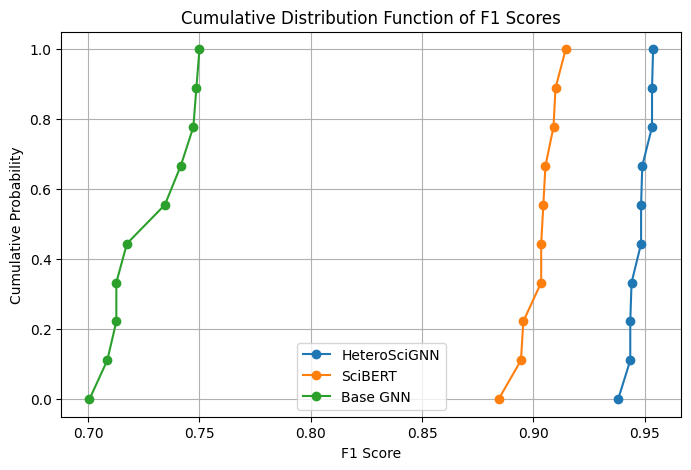

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

baseGNN_f1_scores = np.array([metrics['f1_t'] for metrics in baseGNN_test_metrics_loaded])



# Sorting scores for CDF
gnn_sorted_scores = np.sort(gnn_f1_scores)
scibert_sorted_scores = np.sort(scibert_f1_scores)
baseGNN_sorted_scores = np.sort(baseGNN_f1_scores)

# Calculating CDF
gnn_yvals = np.arange(len(gnn_sorted_scores))/float(len(gnn_sorted_scores)-1)
scibert_yvals = np.arange(len(scibert_sorted_scores))/float(len(scibert_sorted_scores)-1)
baseGNN_yvals = np.arange(len(baseGNN_sorted_scores))/float(len(baseGNN_sorted_scores)-1)

# Plotting CDF
plt.figure(figsize=(8, 5))
plt.plot(gnn_sorted_scores, gnn_yvals, label='HeteroSciGNN', marker='o')
plt.plot(scibert_sorted_scores, scibert_yvals, label='SciBERT', marker='o')
plt.plot(baseGNN_sorted_scores, baseGNN_yvals, label='Base GNN', marker='o')


plt.title('Cumulative Distribution Function of F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.savefig('Cumulative_Distribution_F1.png')
plt.show()


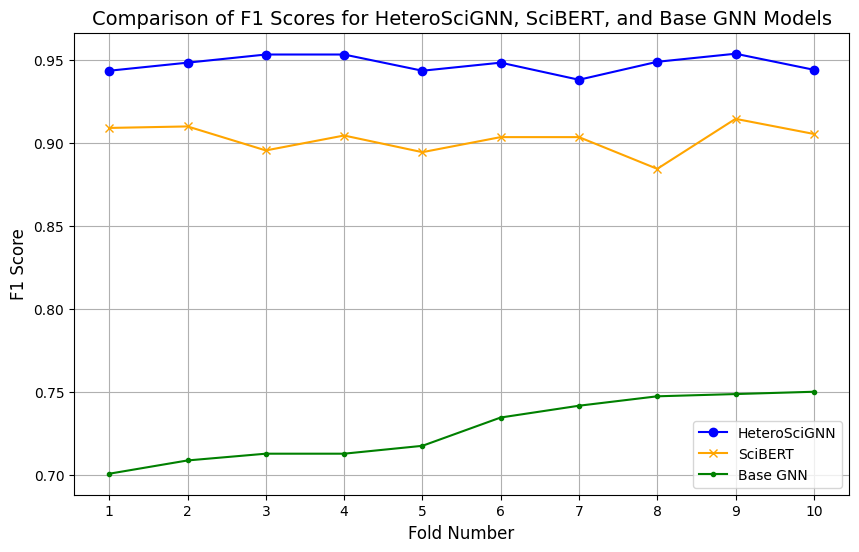

In [ ]:
# The folds
folds = np.arange(1, len(gnn_f1_scores) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(folds, gnn_f1_scores, marker='o', label='HeteroSciGNN', linestyle='-', color='blue')
plt.plot(folds, scibert_f1_scores, marker='x', label='SciBERT', linestyle='-', color='orange')
plt.plot(folds, baseGNN_sorted_scores, marker='.', label='Base GNN', linestyle='-',  color='green')


# Adding titles and labels
plt.title('Comparison of F1 Scores for HeteroSciGNN, SciBERT, and Base GNN Models', fontsize=14)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(folds)  # Set x-ticks to be fold numbers
plt.legend(fontsize=12)


plt.legend()
plt.grid(True)
plt.savefig('Comparison_F1_Scores_3_models.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

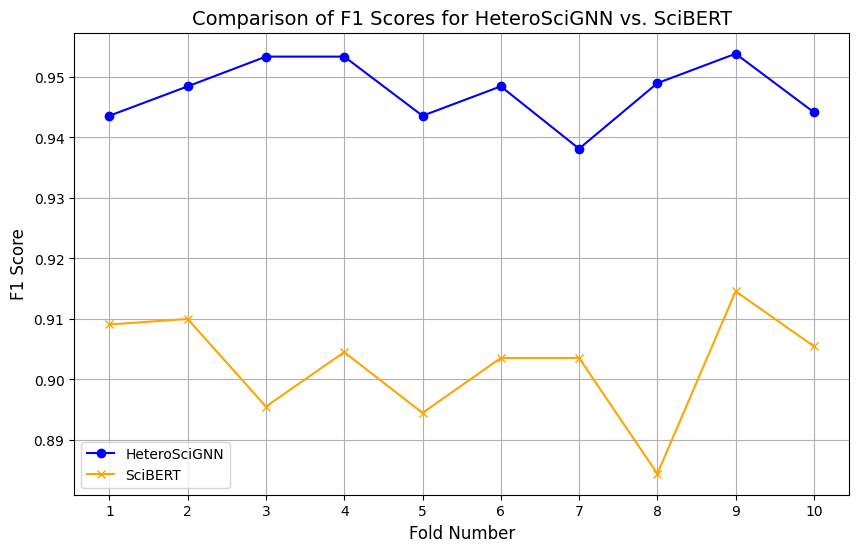

In [ ]:
# The folds
folds = np.arange(1, len(gnn_f1_scores) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(folds, gnn_f1_scores, marker='o', label='HeteroSciGNN', linestyle='-', color='blue')
plt.plot(folds, scibert_f1_scores, marker='x', label='SciBERT', linestyle='-', color='orange')


# Adding titles and labels
plt.title('Comparison of F1 Scores for HeteroSciGNN vs. SciBERT', fontsize=14)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(folds)  # Set x-ticks to be fold numbers
plt.legend(fontsize=12)


plt.legend()
plt.grid(True)
plt.savefig('Comparison_F1_Scores_2_models.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
# Extract ROC-AUC scores from the GNN model's test metrics
gnn_roc_auc_scores = np.array([metrics['roc_auc_t'] for metrics in GNN_test_fold_metrics])
print(gnn_roc_auc_scores)

# Extract ROC-AUC scores from the SciBERT model's test metrics
scibert_roc_auc_scores = np.array([metrics['eval_roc_auc'] for metrics in SciBERT_test_fold_metrics])
print(scibert_roc_auc_scores)

# Perform Shapiro-Wilk Test for normality
gnn_roc_auc_normality = stats.shapiro(gnn_roc_auc_scores)
scibert_roc_auc_normality = stats.shapiro(scibert_roc_auc_scores)
print("\nGNN ROC-AUC Normality Test:", gnn_roc_auc_normality)
print("SciBERT ROC-AUC Normality Test:", scibert_roc_auc_normality)

# Interpretation of Shapiro-Wilk Test results
print("\nInterpretation: GNN ROC-AUC scores are" + (" not" if gnn_roc_auc_normality.pvalue < 0.05 else "") + " normally distributed.")
print("Interpretation: SciBERT ROC-AUC scores are" + (" not" if scibert_roc_auc_normality.pvalue < 0.05 else "") + " normally distributed.")

# Perform Welch's t-test (does not assume equal variances)
roc_auc_t_test_result = stats.ttest_ind(gnn_roc_auc_scores, scibert_roc_auc_scores, equal_var=False)
print("\nROC-AUC Scores t-test Result:", roc_auc_t_test_result)

# Interpretation of Welch's t-test results
print("Interpretation: There is" + (" a" if roc_auc_t_test_result.pvalue < 0.05 else " no") + " statistically significant difference in ROC-AUC scores between GNN and SciBERT models.")

[0.98168421 0.97631579 0.98494737 0.98389474 0.97168421 0.98031579
 0.98557895 0.98642105 0.98442105 0.97568421]
[0.96326316 0.96210526 0.96221053 0.96357895 0.96778947 0.96378947
 0.96957895 0.96378947 0.96452632 0.96557895]

GNN ROC-AUC Normality Test: ShapiroResult(statistic=0.8947924375534058, pvalue=0.19188562035560608)
SciBERT ROC-AUC Normality Test: ShapiroResult(statistic=0.8725337982177734, pvalue=0.10698863118886948)

Interpretation: GNN ROC-AUC scores are normally distributed.
Interpretation: SciBERT ROC-AUC scores are normally distributed.

ROC-AUC Scores t-test Result: TtestResult(statistic=9.409724636751754, pvalue=3.702597573747598e-07, df=12.967221679496905)
Interpretation: There is a statistically significant difference in ROC-AUC scores between GNN and SciBERT models.


## 7.II. Roc-Auc Evaluation

In [ ]:
# Calculate the mean and standard deviation of the TPRs
mean_tpr = np.mean(GNN_all_tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure it ends at 1
std_tpr = np.std(GNN_all_tprs, axis=0)

# Calculate the mean AUC
mean_auc = np.mean(GNN_all_aucs)
std_auc = np.std(GNN_all_aucs)

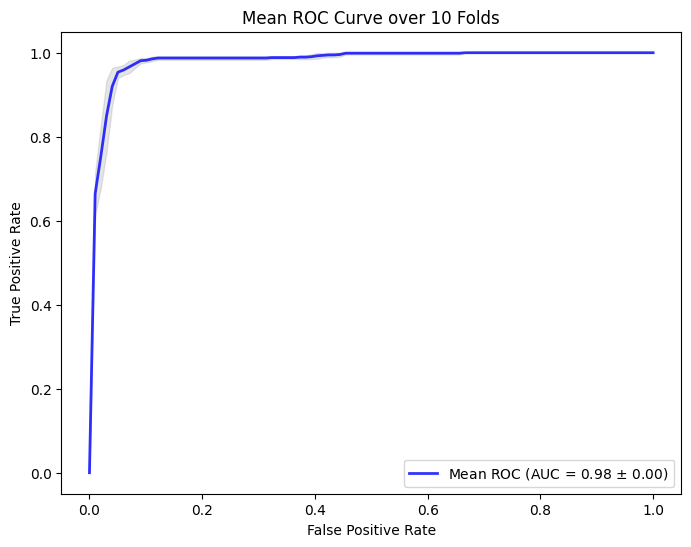

In [ ]:

# Plot the mean ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=0.8)

# Fill the area between the mean +/- std
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve over 10 Folds')
plt.legend(loc="lower right")
plt.show()


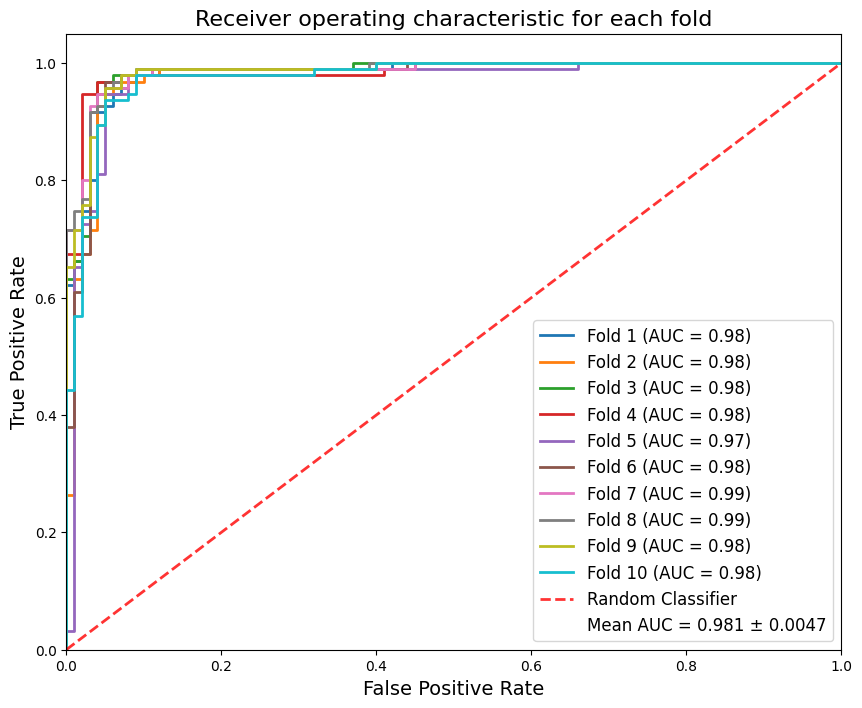

In [ ]:

# Define a list of colors for your plots
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(10, 8))  # Adjust figure size

# Assuming you have defined GNN_fold_fprs, GNN_fold_tprs, and GNN_fold_aucs elsewhere in your code
for i, color in enumerate(colors[:10]):  # Use the first 10 colors for folds
    plt.plot(GNN_fold_fprs[i], GNN_fold_tprs[i], lw=2, color=color, label=f'Fold {i+1} (AUC = {GNN_fold_aucs[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Random Classifier', alpha=.8)

mean_auc = np.mean(GNN_fold_aucs)
std_auc = np.std(GNN_fold_aucs)
plt.plot([], [], ' ', label=f'Mean AUC = {mean_auc:.3f} ± {std_auc:.4f}', color='red')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the font size for the axis labels and title
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic for each fold', fontsize=16)

# Set the font size for the legend
plt.legend(loc="lower right", fontsize=12)

plt.savefig('ROC_AUC.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()


## 7.III. TSNE

<ipython-input-175-6cde29ad330a>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:,0], z[:,1], s=70, c=color, cmap="Set2")


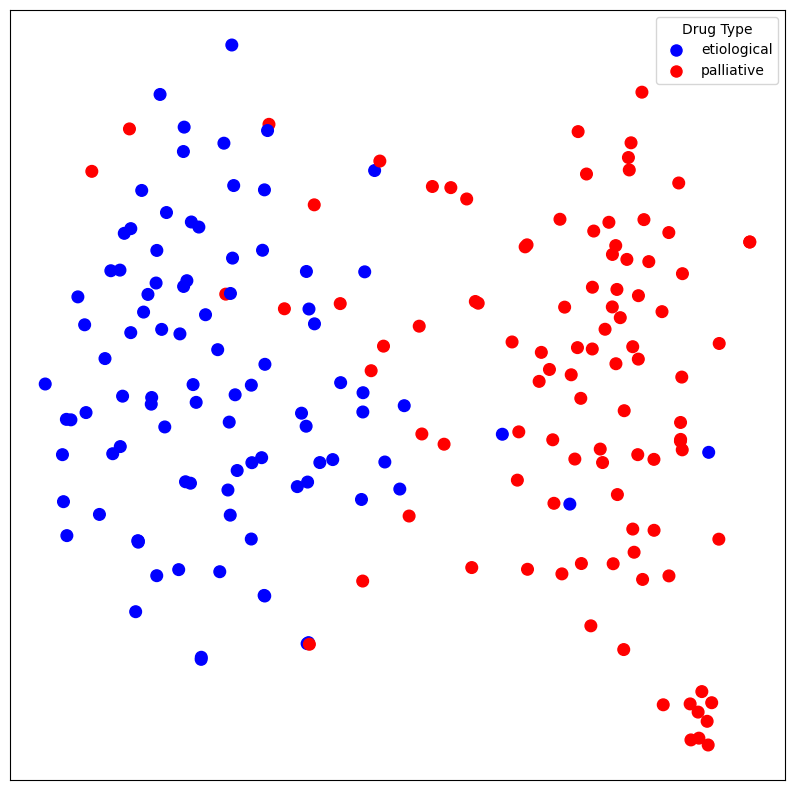

In [ ]:
def visualize_tsn(h, labels):
    color = generate_colors_based_on_labels(labels)
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    scatter = plt.scatter(z[:,0], z[:,1], s=70, c=color, cmap="Set2")

    # Create a legend
    color_map = {'etiological': 'blue', 'palliative': 'red'}
    labels = list(color_map.keys())
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label], markersize=10) for label in labels]
    plt.legend(handles, labels, title='Drug Type')
    plt.show()
def generate_colors_based_on_labels(labels):
    """
    Map labels to colors.
    Args:
    - labels (Tensor or array): Array of labels, each either 0 (for 'etiological') or 1 (for 'palliative').

    Returns:
    - colors (array): Array of colors corresponding to each label.
    """
    # Adjust the label mapping based on your actual label encoding
    label_map = {1: 'etiological', 0: 'palliative'}
    color_map = {'etiological': 'blue', 'palliative': 'red'}
        # Convert tensor labels to numpy array if they are not already
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    # Map numeric labels to string labels and then to colors
    colors = np.array([color_map[label_map[label]] for label in labels])
    return colors


model = HeteroSciGNN()  # Initialize the model
model.load_state_dict(torch.load('HeteroSciGNN.pth'))  # Load the saved state dictionary
data = torch.load('hetero_data.pt')
model.eval()  # Set the model to evaluation mode



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = model.to(device)

model.eval()
with torch.no_grad():
    # Get embeddings for all nodes
    all_embeddings = model(data.x_dict, data.edge_index_dict, return_intermediate=True)

    # Extract embeddings and labels for the test set
    test_mask = data['drug'].test_mask
    test_embeddings = all_embeddings[test_mask]
    test_labels = data['drug'].y[test_mask].cpu().numpy()

    # Visualize the test set embeddings with t-SNE
    visualize_tsn(test_embeddings.cpu().numpy(), test_labels)





In [ ]:



# # Now, let's plot the ROC curves
# plt.figure(figsize=(10, 7))
# num_epochs = len(roc_results)
# for i, (fpr, tpr, roc_auc, f_score) in enumerate(roc_results):
#     if i == 73:  # plot the the i epoch
#         plt.plot(fpr, tpr, label=f'AUC: {roc_auc:.3f}, F-Score: {f_score:.1f}')

# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic curve')
# plt.legend(loc="lower right")
# plt.savefig('ROCV_V1.pdf', dpi=800)

# plt.show()

In [ ]:
# # Initialize the model first
# model = HeteroGNN()
# model.load_state_dict(torch.load("best_model_parameters.pt"))
# model.eval()  # Set the model to evaluation mode
# print("Model parameters loaded.")
# embeddings = torch.load('embeddings.pt')


# acc, recall, precision, f_score, roc_auc, fpr, tpr = test()

# # Save the ROC results
# roc_results = [(fpr, tpr, roc_auc)]

# plt.figure(figsize=(10, 7))
# plt.plot(fpr, tpr, label=f'AUC: {roc_auc:.3f}, F-Score: {f_score:.1f}')
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
# plt.legend(loc="lower right")
# plt.savefig('ROCV_V1.png', dpi=800)
# plt.show()


# 8. Generate Figures

## 8.I. Exploratory Data Analysis

In [ ]:
# Extract rows where Interaction Type is 'drug_target'
data = df_all[df_all['Interaction Type'] == 'drug_target'].drop_duplicates(subset=['Source Name'])

# Define a function for categorizing 'MoA'
def categorize_moa(moa):
    if 'e' in moa:
        return 'Etiological'
    elif 'p' in moa:
        return 'Palliative'
    else:
        return 'Both'

# Apply the function to the 'MoA' column
data['MoA'] = data['MoA'].apply(categorize_moa)
print(data.head())

  Source Name Target Name          MoA ATC class  \
0     DB00001          F2   Palliative         B   
1     DB00002      FCGR1A  Etiological         L   
2     DB00004       IL2RB  Etiological         L   
3     DB00005         TNF   Palliative         L   
4     DB00006          F2   Palliative         B   

                                Drug_Description_New Source Type Target Type  \
0  Lepirudin is a protein-based direct thrombin i...        Drug        Gene   
1  Cetuximab is an endothelial growth factor rece...        Drug        Gene   
2  Denileukin diftitox is a recombinant cytotoxic...        Drug        Gene   
3  Etanercept is a protein therapy based on the b...        Drug        Gene   
4  Bivalirudin is a direct thrombin inhibitor use...        Drug        Gene   

  Interaction Type  
0      drug_target  
1      drug_target  
2      drug_target  
3      drug_target  
4      drug_target  


Palliative     49.653122
Etiological    46.828543
Both            3.518335
Name: MoA, dtype: float64


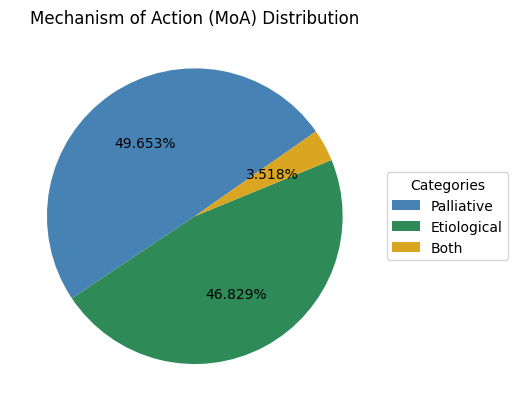

In [ ]:
categories = [ 'Palliative', 'Etiological', 'Both']

# Define colors for each 'MoA'
colors = [ 'steelblue', 'seagreen', 'goldenrod']

# Count the occurrences of each 'MoA'
moa_counts = data['MoA'].value_counts()

# Calculate percentages for each 'MoA'
moa_percentages = (moa_counts / moa_counts.sum()) * 100
print(moa_percentages)

# Create pie chart with specified colors
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(moa_percentages, colors=colors, autopct='%.3f%%', startangle=35)
ax.set_title('Mechanism of Action (MoA) Distribution')

# Create the legend for the chart
ax.legend(wedges, categories, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Save and show the plot
plt.axis('off')
plt.savefig('EvsP.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show() # Display the chart

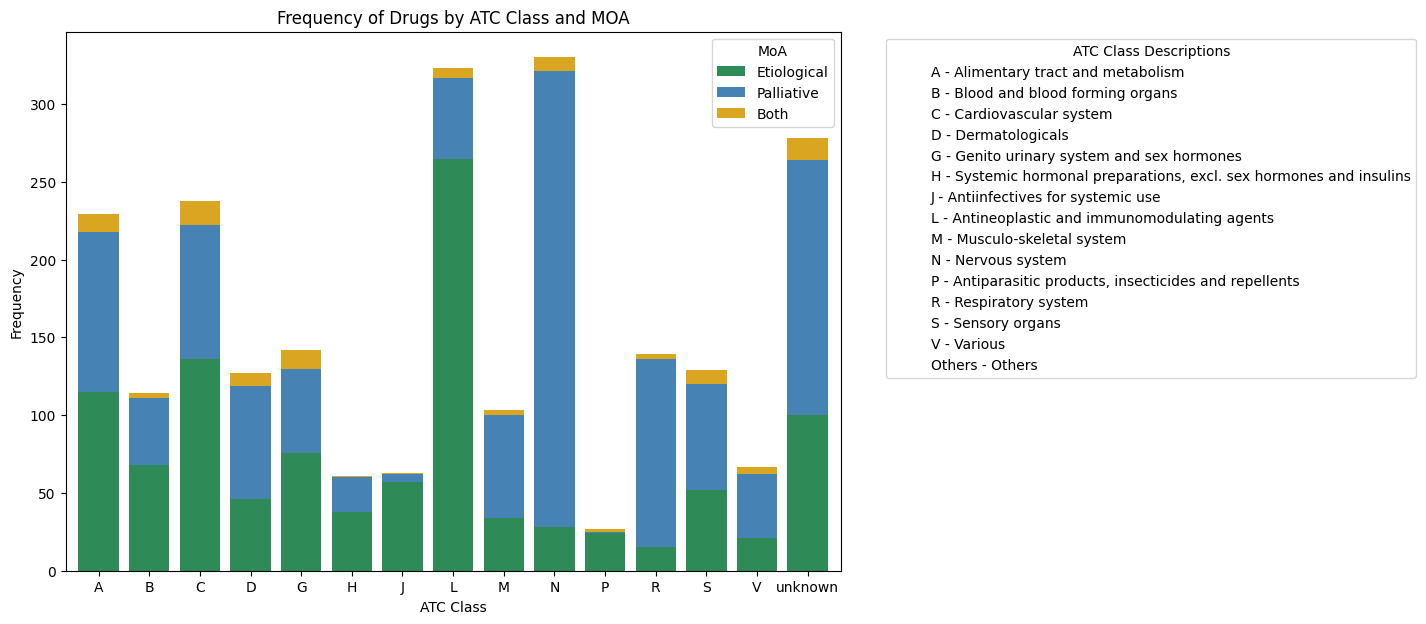

In [ ]:
# Define ATC classes as a dictionary
atc_classes = {
   "A": "Alimentary tract and metabolism",
   "B": "Blood and blood forming organs",
   "C": "Cardiovascular system",
   "D": "Dermatologicals",
   "G": "Genito urinary system and sex hormones",
   "H": "Systemic hormonal preparations, excl. sex hormones and insulins",
   "J": "Antiinfectives for systemic use",
   "L": "Antineoplastic and immunomodulating agents",
   "M": "Musculo-skeletal system",
   "N": "Nervous system",
   "P": "Antiparasitic products, insecticides and repellents",
   "R": "Respiratory system",
   "S": "Sensory organs",
   "V": "Various",
   "Others": "Others"
}

# Expand the 'ATC class' column into multiple rows
atc_expanded = data['ATC class'].str.split(',').apply(pd.Series, 1).stack()
atc_expanded.index = atc_expanded.index.droplevel(-1)
atc_expanded.name = 'ATC_Class'
data_expanded = data.join(atc_expanded)

# Ensure the ATC_Class column only has the letter codes
data_expanded['ATC_Class'] = data_expanded['ATC_Class'].str.strip()

# Group and count occurrences
grouped_data = data_expanded.groupby(['ATC_Class', 'MoA']).size().unstack(fill_value=0)
# Define colors for each 'MoA'
moa_colors = {
    'Both': 'goldenrod',
    'Palliative': 'steelblue',
    'Etiological': 'seagreen',

}

moa_order = ['Etiological', 'Palliative', 'Both']  # Define the order for coloring

# Reorder the columns of grouped_data so that 'Both' is last (for stacking order)
reordered_columns = [col for col in grouped_data if col != 'Both'] + ['Both']
grouped_data = grouped_data[reordered_columns]


# Plot the stacked bar chart
ax = grouped_data.plot(kind='bar', stacked=True,  width=0.8, color=[moa_colors[moa] for moa in moa_order], figsize=(10, 7))
ax.set_xlabel('ATC Class')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Drugs by ATC Class and MOA')
ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal') # Rotate x-axis labels to vertical

# Create legend for 'MoA'
moa_handles, moa_labels = ax.get_legend_handles_labels()
moa_legend = ax.legend(moa_handles, moa_order, title='MoA', loc='upper right')

# Create custom legend for ATC classes without colors
atc_legend_items = [Line2D([0], [0], marker='o', color='w', label=f'{key} - {desc}',
                           markersize=0, markerfacecolor='none') for key, desc in atc_classes.items()]

# Add the ATC class descriptions legend
atc_legend = ax.legend(handles=atc_legend_items, title='ATC Class Descriptions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')

# Ensure that MoA legend remains visible
ax.add_artist(moa_legend)

# Save and show the plot
plt.savefig('EvsP02.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show() # Display the chart

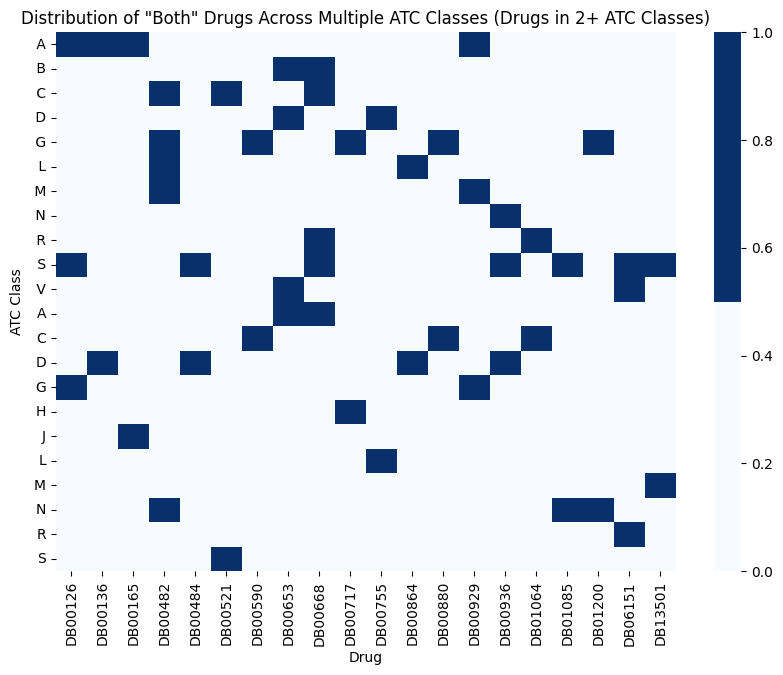

Distribution of 'Both' drugs across ATC classes:
1    51
2    13
3     4
4     1
5     2
Name: ATC_Class, dtype: int64

Total number of drugs labeled as 'Both': 71


In [ ]:
# Filter to include only drugs labeled as 'Both'
both_data = data[data['MoA'] == 'Both']

# Extracting unique drug names
unique_drugs = data.loc[data['Source Type'] == 'Drug', 'Source Name'].unique().tolist()

# Filter to include only entries labeled as 'Both'
both_data = data[(data['MoA'] == 'Both') & (data['Source Name'].isin(unique_drugs))]

# Expand the 'ATC class' column for the filtered data
atc_expanded_both = both_data['ATC class'].str.split(',').apply(pd.Series, 1).stack()
atc_expanded_both.index = atc_expanded_both.index.droplevel(-1)
atc_expanded_both.name = 'ATC_Class'
both_data_expanded = both_data.join(atc_expanded_both)

# Count how many ATC classes each drug is associated with
drug_atc_distribution = both_data_expanded.groupby('Source Name')['ATC_Class'].nunique()

# Filter to keep only drugs present in 2 or more ATC classes
drugs_in_multiple_atc = drug_atc_distribution[drug_atc_distribution >= 2].index.tolist()

# Filter the original expanded data to include only these drugs
filtered_data = both_data_expanded[both_data_expanded['Source Name'].isin(drugs_in_multiple_atc)]

# Recalculate the occurrences of ATC classes for these filtered drugs
filtered_drug_atc_counts = filtered_data.groupby(['Source Name', 'ATC_Class']).size().reset_index(name='Count')

# Pivot the data for the filtered drugs
filtered_pivot_data = filtered_drug_atc_counts.pivot(index='ATC_Class', columns='Source Name', values='Count').fillna(0)

cmap = sns.color_palette(["#f7fbff", "#08306b"])  # Light blue for absence, dark blue for presence

# Plot a heatmap for the filtered data
plt.figure(figsize=(10, 7))
sns.heatmap(filtered_pivot_data, annot=False, cmap=cmap)
plt.ylabel('ATC Class')
plt.xlabel('Drug')
plt.title('Distribution of "Both" Drugs Across Multiple ATC Classes (Drugs in 2+ ATC Classes)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Save and show the plot
plt.savefig('DrugDistributionMultipleATC.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()


# Count how many drugs are in 1, 2, 3,... ATC classes
atc_class_distribution = drug_atc_distribution.value_counts().sort_index()

# Print the distribution
print("Distribution of 'Both' drugs across ATC classes:")
print(atc_class_distribution)

# Total number of drugs labeled as 'Both'
total_both_drugs = len(drug_atc_distribution)
print(f"\nTotal number of drugs labeled as 'Both': {total_both_drugs}")


## 8.II. Generate Heterogeneous Network Using NetworkX

In [ ]:
# Initialize a NetworkX graph
G = nx.Graph()
# Create a mapping from drug name to MoA label
drug_labels = drug_info_df.set_index('Source Name')['MoA'].to_dict()

# Add nodes
for drug in unique_drugs:
    G.add_node(drug, node_type='drug', MoA=drug_labels.get(drug, 'unknown'))
for disease in unique_diseases:
    G.add_node(disease, node_type='disease')
for gene in all_genes:
    G.add_node(gene, node_type='gene')

# Add edges for Drug-Gene interactions
for src, tgt in zip(source_nodes_dg, target_nodes_dg):
    G.add_edge(unique_drugs[src], all_genes[tgt], edge_type='drug_gene')

# Add edges for Disease-Gene interactions
for src, tgt in zip(source_nodes_pg, target_nodes_pg):
    G.add_edge(unique_diseases[src], all_genes[tgt], edge_type='disease_gene')

# Add edges for Gene-Gene interactions (PPI)
for src, tgt in zip(source_nodes_gg, target_nodes_gg):
    G.add_edge(all_genes[src], all_genes[tgt], edge_type='gene_gene')


In [ ]:
# Now extract the different node sets
drug_nodes = {node for node, data in G.nodes(data=True) if data.get('node_type') == 'drug'}
disease_nodes = {node for node, data in G.nodes(data=True) if data.get('node_type') == 'disease'}
gene_nodes = {node for node, data in G.nodes(data=True) if data.get('node_type') == 'gene'}

In [ ]:
print("Graph Properties:")
print(f"Total number of nodes: {G.number_of_nodes()}")
print(f"Total number of edges: {G.number_of_edges()}")

# Node types: Drug, Disease, Gene
print(f"Number of Drug nodes: {sum(1 for _, attr in G.nodes(data=True) if attr['node_type'] == 'drug')}")
print(f"Number of Disease nodes: {sum(1 for _, attr in G.nodes(data=True) if attr['node_type'] == 'disease')}")
print(f"Number of Gene nodes: {sum(1 for _, attr in G.nodes(data=True) if attr['node_type'] == 'gene')}")

# Edge types: Drug-Gene, Disease-Gene, Gene-Gene
print(f"Number of Drug-Gene edges: {sum(1 for _, _, attr in G.edges(data=True) if attr['edge_type'] == 'drug_gene')}")
print(f"Number of Disease-Gene edges: {sum(1 for _, _, attr in G.edges(data=True) if attr['edge_type'] == 'disease_gene')}")
print(f"Number of Gene-Gene (PPI) edges: {sum(1 for _, _, attr in G.edges(data=True) if attr['edge_type'] == 'gene_gene')}")


Graph Properties:
Total number of nodes: 41562
Total number of edges: 754088
Number of Drug nodes: 1947
Number of Disease nodes: 8156
Number of Gene nodes: 31459
Number of Drug-Gene edges: 9775
Number of Disease-Gene edges: 27692
Number of Gene-Gene (PPI) edges: 716621


## 8.III. Heterogeneous Sub-Graph: Colorectal Cancer

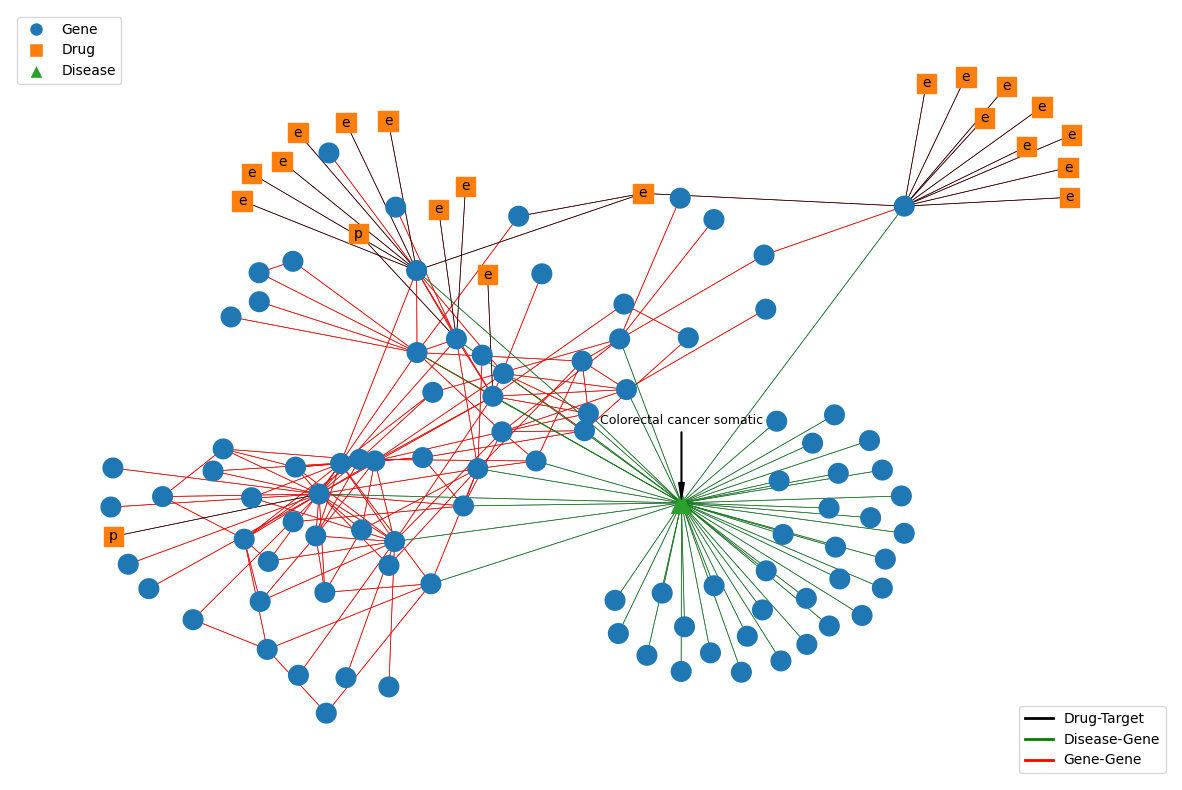

In [ ]:
# Find the highest degree 'disease' node
disease_nodes = [node for node in G.nodes if G.nodes[node]['node_type'] == 'disease']
degree_dict = {node: G.degree(node) for node in disease_nodes}
highest_degree_node = max(degree_dict, key=degree_dict.get)

# Get all neighbors of the highest degree 'disease' node and its neighbors
neighbors = list(G.neighbors(highest_degree_node))
all_neighbors = set(neighbors)
for neighbor in neighbors:
    all_neighbors.update(G.neighbors(neighbor))

# Create a new empty graph to store the subgraph
H = nx.Graph()

# Add 'gene' and 'drug' nodes to the subgraph H that are in all_neighbors
for node_type in ['gene', 'drug']:
    nodes_of_type = [node for node in all_neighbors if G.nodes[node]['node_type'] == node_type][:50]
    for node in nodes_of_type:
        H.add_node(node, **G.nodes[node])

# Add the highest degree 'disease' node to the graph H along with their attributes
H.add_node(highest_degree_node, **G.nodes[highest_degree_node])

# Add the first-level neighbors of the highest degree 'disease' node to the graph H
for neighbor in neighbors:
    H.add_node(neighbor, **G.nodes[neighbor])

# Add the edges between the nodes in H using the edges from the original graph G, excluding self-loops
for edge in G.edges(data=True):
    if edge[0] != edge[1] and edge[0] in H.nodes and edge[1] in H.nodes:
        H.add_edge(edge[0], edge[1], **edge[2])

# Compute the layout for visualization
pos = nx.spring_layout(H, seed=42)

# Set the figure size
plt.figure(figsize=(15, 10))

# Draw nodes with different colors and shapes based on their type
node_colors = ['#1f77b4' if H.nodes[node]['node_type'] == 'gene' else
               '#ff7f0e' if H.nodes[node]['node_type'] == 'drug' else
               '#2ca02c' for node in H.nodes]
node_shapes = ['o' if H.nodes[node]['node_type'] == 'gene' else
               's' if H.nodes[node]['node_type'] == 'drug' else
               '^' for node in H.nodes]

# Draw the nodes
for node_type, shape in [('gene', 'o'), ('drug', 's'), ('disease', '^')]:
    nx.draw_networkx_nodes(H, pos, node_shape=shape,
                           nodelist=[node for node in H.nodes if H.nodes[node]['node_type'] == node_type],
                           node_color=[color for node, color in zip(H.nodes, node_colors) if H.nodes[node]['node_type'] == node_type],
                           node_size=200)  # Node size set to 200


# Draw edges with different colors based on their type
edge_colors = ['#d62728' if 'edge_type' in H.edges[edge] and H.edges[edge]['edge_type'] == 'drug_gene' else
               '#9467bd' if 'edge_type' in H.edges[edge] and H.edges[edge]['edge_type'] == 'disease_gene' else
               '#8c564b' for edge in H.edges]

nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=0.5)

# Add labels for drugs and diseases
# Draw node labels for drugs with 'e' or 'p' instead of the drug name
drug_labels = {node: ('e' if G.nodes[node]['MoA'] == 1 else 'p') for node in H.nodes() if G.nodes[node]['node_type'] == 'drug'}
nx.draw_networkx_labels(H, pos, labels=drug_labels, font_size=10, font_color='black')


# Draw label for the highest degree phenotype node with smaller font size
label_pos = {highest_degree_node: (pos[highest_degree_node][0], pos[highest_degree_node][1]+0.21)}
nx.draw_networkx_labels(H, label_pos, labels={highest_degree_node: highest_degree_node}, font_size=9, font_color='black')

# Add a smaller arrow annotation pointing to the highest degree phenotype node and positioned a bit higher
plt.annotate('', xy=pos[highest_degree_node], xytext=(pos[highest_degree_node][0], pos[highest_degree_node][1]+0.19),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=4))

# Draw edges with specified colors based on their type
edge_colors = []
for u, v, data in H.edges(data=True):
    etype = data.get('edge_type', 'gene_gene')
    if etype == 'drug_gene':
        edge_colors.append('black')  # Drug-Gene edges are green
    elif etype == 'disease_gene':
        edge_colors.append('green')  # Disease-Gene edges are black
    else:  # 'gene_gene' or other edge types
        edge_colors.append('red')  # Gene-Gene edges are red
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=0.5)


# Legends for nodes
gene_patch = Line2D([], [], marker='o', color='w', label='Gene', markersize=10, markerfacecolor='#1f77b4')
drug_patch = Line2D([], [], marker='s', color='w', label='Drug', markersize=10, markerfacecolor='#ff7f0e')
disease_patch = Line2D([], [], marker='^', color='w', label='Disease', markersize=10, markerfacecolor='#2ca02c')
node_legend = plt.legend(handles=[gene_patch, drug_patch, disease_patch], loc='upper left')

# Create a legend for the edge types
edge_legend_items = [
    Line2D([0], [0], color='black', lw=2, label='Drug-Target'),
    Line2D([0], [0], color='green', lw=2, label='Disease-Gene'),
    Line2D([0], [0], color='red', lw=2, label='Gene-Gene')
]

# Add both legends to the plot
plt.gca().add_artist(node_legend)
edge_legend = plt.legend(handles=edge_legend_items, loc='lower right')

# Save and show the plot
plt.axis('off')
plt.savefig('heterogeneous_networks.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()



Calculating best minimal value for power law fit


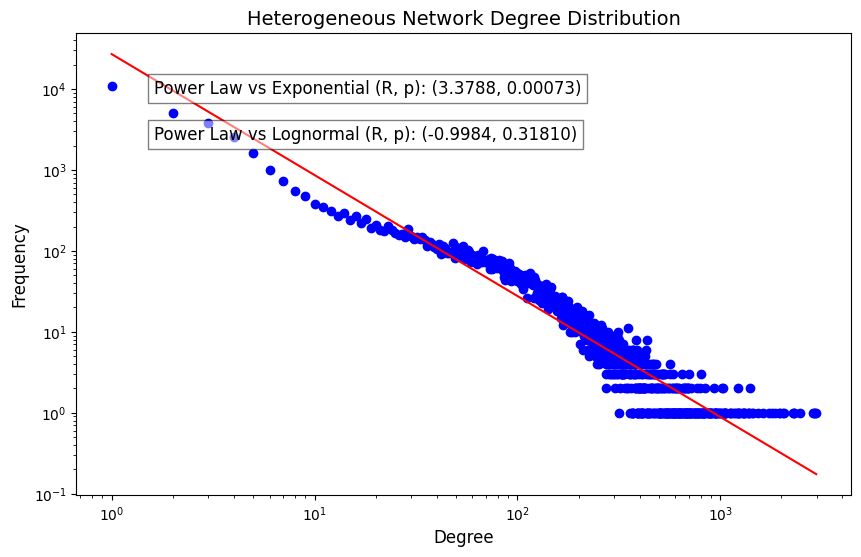

In [ ]:
# import powerlaw
# import collections
# import pandas as pd
# import random
# import csv
# import networkx as nx
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import pandas as pd
# from collections import Counter
# import numpy as np

# # Calculate the degree of each node
# degree_sequence = [d for n, d in G.degree()]

# # Fit the degree distribution to a power law model
# fit = powerlaw.Fit(np.array(degree_sequence))

# # Compare the fitted power law model to other distributions
# R_power_law, p_power_law = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
# R_exponential, p_exponential = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)

# # Count the frequency of each degree value
# degree_counts = Counter(degree_sequence)

# # Separate the degree values and their corresponding frequencies
# degrees = list(degree_counts.keys())
# frequencies = list(degree_counts.values())

# # Filter out the zero degrees or frequencies
# non_zero_indices = np.logical_and(np.array(degrees) > 0, np.array(frequencies) > 0)
# degrees = list(np.array(degrees)[non_zero_indices])
# frequencies = list(np.array(frequencies)[non_zero_indices])

# # Convert the degrees and frequencies to numpy arrays
# degrees_np = np.array(degrees)
# frequencies_np = np.array(frequencies)

# # Create a scatter plot of the degree distribution on a log-log scale
# plt.figure(figsize=(10, 6))
# plt.scatter(degrees_np, frequencies_np, color='b')
# plt.xscale('log')
# plt.yscale('log')

# # Calculate the coefficients of the line of best fit in log space
# coefficients = np.polyfit(np.log(degrees_np), np.log(frequencies_np), 1)

# # Generate the x-values for the trendline in log space
# trendline_x_log = np.linspace(min(np.log(degrees_np)), max(np.log(degrees_np)), 100)

# # Generate the y-values for the trendline in log space
# trendline_y_log = coefficients[1] + coefficients[0] * trendline_x_log

# # Convert the trendline back to the original scale
# trendline_x = np.exp(trendline_x_log)
# trendline_y = np.exp(trendline_y_log)

# # Plot the trendline
# plt.plot(trendline_x, trendline_y, color='r')

# # Add the p-values for different distributions to the graph in rectangles
# plt.text(0.1, 0.9, f'Power Law vs Exponential (R, p): ({R_power_law:.4f}, {p_power_law:.5f})',
#          horizontalalignment='left',
#          verticalalignment='top',
#          transform=plt.gca().transAxes,
#          fontsize=12,
#          bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

# plt.text(0.1, 0.8, f'Power Law vs Lognormal (R, p): ({R_exponential:.4f}, {p_exponential:.5f})',
#          horizontalalignment='left',
#          verticalalignment='top',
#          transform=plt.gca().transAxes,
#          fontsize=12,
#          bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

# plt.title('Heterogeneous Network Degree Distribution', fontsize=14)
# plt.xlabel('Degree', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)

# plt.savefig('degree_distribution.png', dpi=800, bbox_inches='tight')

# plt.show()


## 8.IV. Constructing Networks from the Datasets <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Topological Features For PPI & Drug-Target & Disease-Gene Networks.

#### 8.IV.A. Drug-Target Network

In [ ]:
# Extract rows where Interaction Type is 'drug_target'
drug_target_df = df_all[(df_all['Interaction Type'] == 'drug_target')]

unique_drugs = drug_target_df['Source Name'].unique().tolist()
drug_mapping = {drug: i for i, drug in enumerate(unique_drugs)}

unique_genes_drug = drug_target_df['Target Name'].unique().tolist()
genes_drug_mapping = {gene: i for i, gene in enumerate(unique_genes_drug)}

# Drug-Gene interactions based on 'drug_target' interaction type
source_nodes_dg = drug_target_df['Source Name'].map(drug_mapping).dropna().astype(int).values
target_nodes_dg = drug_target_df['Target Name'].map(genes_drug_mapping).dropna().astype(int).values

In [ ]:
# Initialize and build the NetworkX graph
dt_net = nx.Graph()

# Add drug nodes
for drug in unique_drugs:
    dt_net.add_node(drug, node_type='drug')

# Add gene nodes
for gene in unique_genes_drug:
    dt_net.add_node(gene, node_type='gene')

# Add edges for Drug-Gene interactions
for src, tgt in zip(source_nodes_dg, target_nodes_dg):
    dt_net.add_edge(unique_drugs[src], unique_genes_drug[tgt], edge_type='drug_gene')

In [ ]:
# Network statistics
drug_nodes = {node for node, data in dt_net.nodes(data=True) if data.get('node_type') == 'drug'}
gene_nodes = {node for node, data in dt_net.nodes(data=True) if data.get('node_type') == 'gene'}
num_drug_nodes = len(drug_nodes)
num_gene_nodes = len(gene_nodes)
num_edges = dt_net.number_of_edges()

# Connected components
connected_components = list(nx.connected_components(dt_net))
num_connected_components = len(connected_components)
num_isolated_pairs = sum(1 for c in connected_components if len(c) == 2)

# Largest Connected Component (LCC)
largest_cc = max(connected_components, key=len)
LCC_dt = dt_net.subgraph(largest_cc)

# Counting drug and gene nodes in LCC
drug_nodes_LCC = {node for node, data in LCC_dt.nodes(data=True) if data.get('node_type') == 'drug'}
gene_nodes_LCC = {node for node, data in LCC_dt.nodes(data=True) if data.get('node_type') == 'gene'}
num_drug_nodes_LCC = len(drug_nodes_LCC)
num_gene_nodes_LCC = len(gene_nodes_LCC)
num_edges_LCC = LCC_dt.number_of_edges()
num_nodes_LCC = LCC_dt.number_of_nodes()
# Degree analysis in LCC
degree_sequence_LCC = sorted((d for n, d in LCC_dt.degree()), reverse=True)
degree_count_LCC = Counter(degree_sequence_LCC)
most_frequent_degree_LCC = degree_count_LCC.most_common(1)[0][0]

# Output
print(f"Network Statistics:")
print(f"- Number of drug nodes in the entire network: {num_drug_nodes}")
print(f"- Number of gene target nodes in the entire network: {num_gene_nodes}")
print(f"- Number of links (edges) connecting them: {num_edges}")
print(f"- Number of connected components: {num_connected_components}")
print(f"- Number of isolated pairs (standalone drug-target pairs): {num_isolated_pairs}")
print(f"\nLargest Connected Component (LCC):")
print(f"- Total number of nodes in LCC: {num_nodes_LCC}")
print(f"- Number of drug nodes in LCC: {num_drug_nodes_LCC}")
print(f"- Number of gene target nodes in LCC: {num_gene_nodes_LCC}")
print(f"- Number of links (edges) in LCC: {num_edges_LCC}")
print(f"- Most frequent degree in LCC: {most_frequent_degree_LCC}")

Network Statistics:
- Number of drug nodes in the entire network: 2018
- Number of gene target nodes in the entire network: 2232
- Number of links (edges) connecting them: 10250
- Number of connected components: 129
- Number of isolated pairs (standalone drug-target pairs): 75

Largest Connected Component (LCC):
- Total number of nodes in LCC: 3824
- Number of drug nodes in LCC: 1797
- Number of gene target nodes in LCC: 2027
- Number of links (edges) in LCC: 9916
- Most frequent degree in LCC: 1


##### Generate Figure For The Largest Connected Component of the Drug-Target Network

<ipython-input-41-4af582c65c73>:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


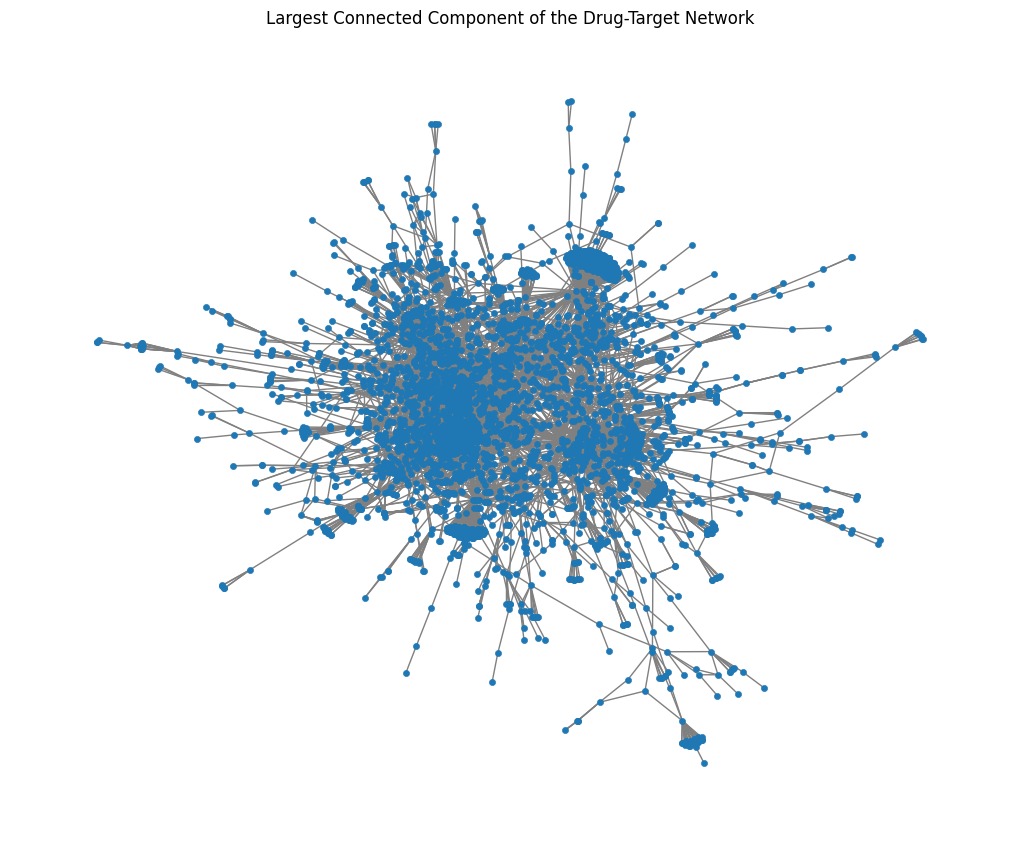

In [ ]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(LCC_dt, seed=24) # Using spring layout for positioning nodes
nx.draw(LCC_dt, pos, with_labels=False, node_size=20, edge_color="gray", linewidths=0.4)
plt.tight_layout()
plt.title("Largest Connected Component of the Drug-Target Network")
plt.show()

#### 8.IV.B. Protein-Protein Interaction (PPI) Network

In [ ]:
# Extract unique genes based on Interaction Type being 'PPI'
PPI_df = df_all[df_all['Interaction Type'] == 'PPI']

# Get unique genes from both 'Source Name' and 'Target Name'
unique_genes_ppi = set(PPI_df['Source Name'].unique()).union(set(PPI_df['Target Name'].unique()))
unique_genes_ppi = list(unique_genes_ppi)  # Convert set back to list
PPI_genes_mapping = {gene: i for i, gene in enumerate(unique_genes_ppi)}

# Gene-Gene interactions (PPI)
source_nodes_gg = PPI_df['Source Name'].map(PPI_genes_mapping).dropna().astype(int).values
target_nodes_gg = PPI_df['Target Name'].map(PPI_genes_mapping).dropna().astype(int).values

Generate PPI Network

In [ ]:
# Initialize a NetworkX graph
PPI = nx.Graph()

# Add gene nodes
for gene in unique_genes_ppi:
    PPI.add_node(gene, node_type='gene')

# Add edges for Gene-Gene interactions (PPI)
for src, tgt in zip(source_nodes_gg, target_nodes_gg):
    PPI.add_edge(unique_genes_ppi[src], unique_genes_ppi[tgt], edge_type='gene_gene')


PPI Topological Features

In [ ]:
# Calculate basic network statistics
num_ppi_nodes = PPI.number_of_nodes()
num_ppi_edges = PPI.number_of_edges()
num_ppi_self_loops = nx.number_of_selfloops(PPI)

# Remove self-loops
PPI.remove_edges_from(nx.selfloop_edges(PPI))

# Identify connected components and calculate statistics
connected_components = list(nx.connected_components(PPI))
num_connected_components = len(connected_components)
num_isolated_nodes = sum(1 for c in connected_components if len(c) == 1)

# Determine the Largest Connected Component (LCC)
largest_cc = max(connected_components, key=len)
LCC_PPI = PPI.subgraph(largest_cc)
num_nodes_LCC = len(largest_cc)
num_edges_LCC = LCC_PPI.number_of_edges()

# Counting gene nodes in the LCC
gene_nodes_LCC = {node for node, data in LCC_PPI.nodes(data=True) if data.get('node_type') == 'gene'}
num_gene_nodes_LCC = len(gene_nodes_LCC)

# Degree analysis in the LCC
degree_sequence = sorted((d for n, d in LCC_PPI.degree()), reverse=True)
degree_count = Counter(degree_sequence)
most_frequent_degree = degree_count.most_common(1)[0][0]

# Calculate the average clustering coefficient in the LCC
avg_clustering_coef = nx.average_clustering(LCC_PPI)

# Output the statistics
print(f"PPI network:")
print(f"- Total number of protein nodes: {num_ppi_nodes}")
print(f"- Total number of edges (excluding self-loops): {num_ppi_edges - num_ppi_self_loops}")
print(f"- Number of self-loop edges: {num_ppi_self_loops}")
print(f"- Number of connected components: {num_connected_components}")
print(f"- Number of isolated protein nodes: {num_isolated_nodes}")
print(f"\nLargest Connected Component (LCC):")
print(f"- Total number of nodes in LCC: {num_nodes_LCC}")
print(f"- Number of gene nodes in LCC: {num_gene_nodes_LCC}")
print(f"- Number of edges in LCC: {num_edges_LCC}")
print(f"- Most frequent degree in LCC: {most_frequent_degree}")
print(f"- Average clustering coefficient in LCC: {avg_clustering_coef}")

PPI network:
- Total number of protein nodes: 19823
- Total number of edges (excluding self-loops): 713333
- Number of self-loop edges: 3288
- Number of connected components: 4
- Number of isolated protein nodes: 3

Largest Connected Component (LCC):
- Total number of nodes in LCC: 19820
- Number of gene nodes in LCC: 19820
- Number of edges in LCC: 713333
- Most frequent degree in LCC: 1
- Average clustering coefficient in LCC: 0.1181460336998495


##### Generate Figure For The Largest Connected Component of the PPI

In [ ]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(LCC_PPI, seed=24)  # Using spring layout for positioning nodes
nx.draw(LCC_PPI, pos, with_labels=False, node_size=20, edge_color="gray", linewidths=0.4)
plt.tight_layout()
plt.title("Largest Connected Component of the PPI Network")
plt.show()

KeyboardInterrupt: ignored

<Figure size 1200x1200 with 0 Axes>

### 8.IV.C. Disease-Gene Network

In [ ]:
# Extract unique genes based on Interaction Type being 'association'
disease_gene_df = df_all[df_all["Interaction Type"] == "association"]

unique_disease = disease_gene_df['Source Name'].unique().tolist()
disease_mapping = {disease: i for i, disease in enumerate(unique_disease)}

unique_gene_association = disease_gene_df['Target Name'].unique().tolist()
gene_association_mapping = {gene: i for i, gene in enumerate(unique_gene_association)}

# Disease-Gene interactions
source_nodes_pg = disease_gene_df['Source Name'].map(disease_mapping).dropna().astype(int).values
target_nodes_pg = disease_gene_df['Target Name'].map(gene_association_mapping).dropna().astype(int).values

Generate Disease-Gene (Diseasome) network

In [ ]:
# Initialize and build the NetworkX graph
diseasome_net = nx.Graph()

# Add disease nodes
for disease in unique_disease:
    diseasome_net.add_node(disease, node_type='disease')

# Add gene nodes
for gene in unique_gene_association:
    diseasome_net.add_node(gene, node_type='gene')

# Add edges for Disease-Gene interactions
for src, tgt in zip(source_nodes_pg, target_nodes_pg):
    diseasome_net.add_edge(unique_disease[src], unique_gene_association[tgt], edge_type='disease_gene')

 Disease-Gene Topological Features

In [ ]:
# Calculate basic network statistics
disease_nodes = {node for node, data in diseasome_net.nodes(data=True) if data.get('node_type') == 'disease'}
gene_nodes = {node for node, data in diseasome_net.nodes(data=True) if data.get('node_type') == 'gene'}
num_disease_nodes = len(disease_nodes)
num_gene_nodes = len(gene_nodes)
num_edges = diseasome_net.number_of_edges()

# Identify connected components and calculate statistics
connected_components = list(nx.connected_components(diseasome_net))
num_connected_components = len(connected_components)
num_isolated_pairs = sum(1 for c in connected_components if len(c) == 2)

# Determine the Largest Connected Component (LCC)
largest_cc = max(connected_components, key=len)
LCC_diseasome = diseasome_net.subgraph(largest_cc)
num_nodes_LCC = len(largest_cc)
num_edges_LCC = LCC_diseasome.number_of_edges()

# Counting disease and gene nodes in the LCC
disease_nodes_LCC = {node for node, data in LCC_diseasome.nodes(data=True) if data.get('node_type') == 'disease'}
gene_nodes_LCC = {node for node, data in LCC_diseasome.nodes(data=True) if data.get('node_type') == 'gene'}
num_disease_nodes_LCC = len(disease_nodes_LCC)
num_gene_nodes_LCC = len(gene_nodes_LCC)

# Degree analysis in the LCC
degree_sequence_LCC = sorted((d for n, d in LCC_diseasome.degree()), reverse=True)
degree_count_LCC = Counter(degree_sequence_LCC)
most_frequent_degree_LCC = degree_count_LCC.most_common(1)[0][0]

# Output the statistics
print(f"Diseasome Network Statistics:")
print(f"- Number of disease nodes in the entire network: {num_disease_nodes}")
print(f"- Number of gene nodes in the entire network: {num_gene_nodes}")
print(f"- Number of links (edges) connecting them: {num_edges}")
print(f"- Number of connected components: {num_connected_components}")
print(f"- Number of isolated pairs (standalone disease-gene pairs): {num_isolated_pairs}")
print(f"\nLargest Connected Component (LCC):")
print(f"- Total number of nodes in LCC: {num_nodes_LCC}")
print(f"- Number of disease nodes in LCC: {num_disease_nodes_LCC}")
print(f"- Number of gene nodes in LCC: {num_gene_nodes_LCC}")
print(f"- Number of links (edges) in LCC: {num_edges_LCC}")
print(f"- Most frequent degree in LCC: {most_frequent_degree_LCC}")

Diseasome Network Statistics:
- Number of disease nodes in the entire network: 8156
- Number of gene nodes in the entire network: 16358
- Number of links (edges) connecting them: 27692
- Number of connected components: 5430
- Number of isolated pairs (standalone disease-gene pairs): 1065

Largest Connected Component (LCC):
- Total number of nodes in LCC: 644
- Number of disease nodes in LCC: 265
- Number of gene nodes in LCC: 379
- Number of links (edges) in LCC: 1493
- Most frequent degree in LCC: 2


#### Generate Figure For The Largest Connected Component of the Diseasome Network

<ipython-input-29-a66efa21a706>:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


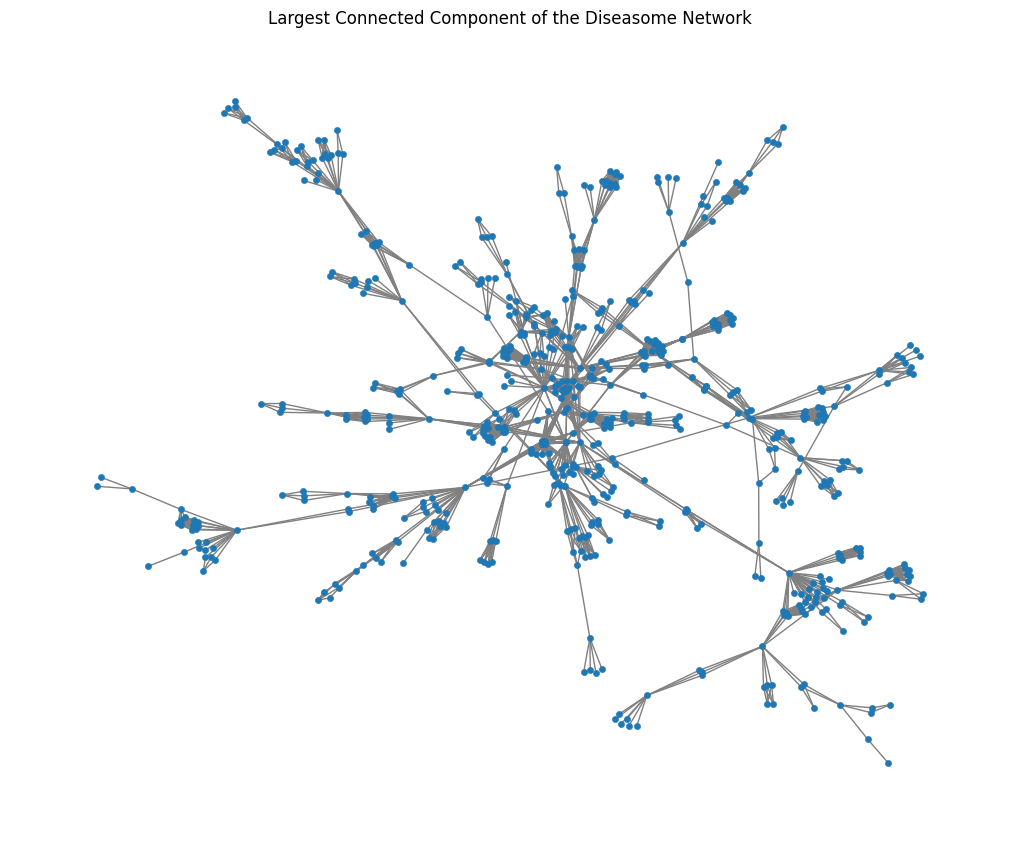

In [ ]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(LCC_diseasome, seed=24)  # Using spring layout for positioning nodes
nx.draw(LCC_diseasome, pos, with_labels=False, node_size=20, edge_color="gray", linewidths=0.4)
plt.tight_layout()
plt.title("Largest Connected Component of the Diseasome Network")
plt.show()

# 9. Realted work - Yildrim

In [ ]:
# Calculate the shortest paths and store in a list
shortest_paths = []

for drug in tqdm(drug_nodes, desc='Calculate path'):
    drug_moa = G.nodes[drug].get('MoA', 'unknown')  # Retrieve MoA of the drug
    for disease in disease_nodes:
        try:
            path = nx.shortest_path(G, source=drug, target=disease)
            intermediate_nodes = set(path[1:-1])
            if intermediate_nodes.issubset(gene_nodes):
                """
                -2 to remove drug and disease from the path length.
                -1 to calculate the distance by the edges.
                for example: path = [DrugA, GeneA, GeneB, GeneC, disease], so the path length is 5.
                But the distance will be 2 because we don't count the drug and disease and calculate the number of edges between GeneA to Gene C.
                """
                path_length = len(path) - 3  # Calculating the path length
                shortest_paths.append((drug, drug_moa, disease, path_length, path))
        except nx.NetworkXNoPath:
            # Record the absence of a path
            shortest_paths.append((drug, drug_moa, None, None, None))

# Filter the shortest paths for each drug
all_shortest_paths = defaultdict(list)
for drug, drug_moa, disease, length, path in shortest_paths:
    if disease is not None:  # If there is a path
        all_shortest_paths[drug].append((drug_moa, disease, length, path))

# Find the shortest path for each drug
unique_shortest_paths = []
for drug, paths in all_shortest_paths.items():
    min_length = min(length for _, _, length, _ in paths)
    for drug_moa, disease, length, path in paths:
        if length == min_length:
            unique_shortest_paths.append((drug, drug_moa, disease, length, path))

# Flatten all_shortest_paths into a list of tuples
arr_all_shortest_paths = []
for drug, paths in all_shortest_paths.items():
    for drug_moa, disease, length, path in paths:
        arr_all_shortest_paths.append((drug, drug_moa, disease, length, path))

Calculate path: 100%|██████████| 1947/1947 [23:32<00:00,  1.38it/s]


Drugs with no path to disease

In [ ]:
drugs_without_paths = drug_nodes - {drug for drug, _, _, _, _ in shortest_paths if _ is not None}
print(drugs_without_paths)
print(len(drugs_without_paths))

for drug in drugs_without_paths:
    drug_moa = G.nodes[drug].get('MoA', 'unknown')  # Retrieve MoA of the drug
    print(f"{drug}, {drug_moa}")

{'DB13007', 'DB00693', 'DB15456', 'DB08949', 'DB05676', 'DB11915', 'DB11732', 'DB13979', 'DB16900'}
9
DB13007, 1
DB00693, 0
DB15456, 0
DB08949, 1
DB05676, 0
DB11915, 0
DB11732, 0
DB13979, 0
DB16900, 1


Save All vs. All dataframe

In [ ]:
# Create DataFrame
df_columns = ['Drug', 'MoA', 'Disease', 'Path Length', 'Path']
df_all = pd.DataFrame(arr_all_shortest_paths, columns=df_columns)

# Save the DataFrame to a compressed csv.gz format
df_all.to_csv('All_shortest_paths_compress.csv.gz', compression='gzip', index=False)
df_all.to_csv('All_shortest_paths.csv', index=False)

Save Unique Shortest Distance dataframe

In [ ]:
# Create DataFrame
df_columns = ['Drug', 'MoA', 'Disease', 'Path Length', 'Path']
df_unique = pd.DataFrame(unique_shortest_paths, columns=df_columns)
# Save the DataFrame to a compressed csv.gz format
df_unique.to_csv('Unique_shortest_paths_compress.csv.gz', compression='gzip', index=False)
df_unique.to_csv('Unique_shortest_paths.csv', index=False)

### 1. **All vs. All Method:** Calculates and counts the shortest distance from each drug to every disease, considering each occurrence of the drug in multiple paths.

In [ ]:
df_all_shortest_paths = pd.read_csv('All_shortest_paths_compress.csv.gz', compression='gzip')

<ipython-input-67-7eba114a47b4>:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  etiological_counts = moa_counts.get(0, pd.Series()).to_dict()
<ipython-input-67-7eba114a47b4>:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  palliative_counts = moa_counts.get(1, pd.Series()).to_dict()


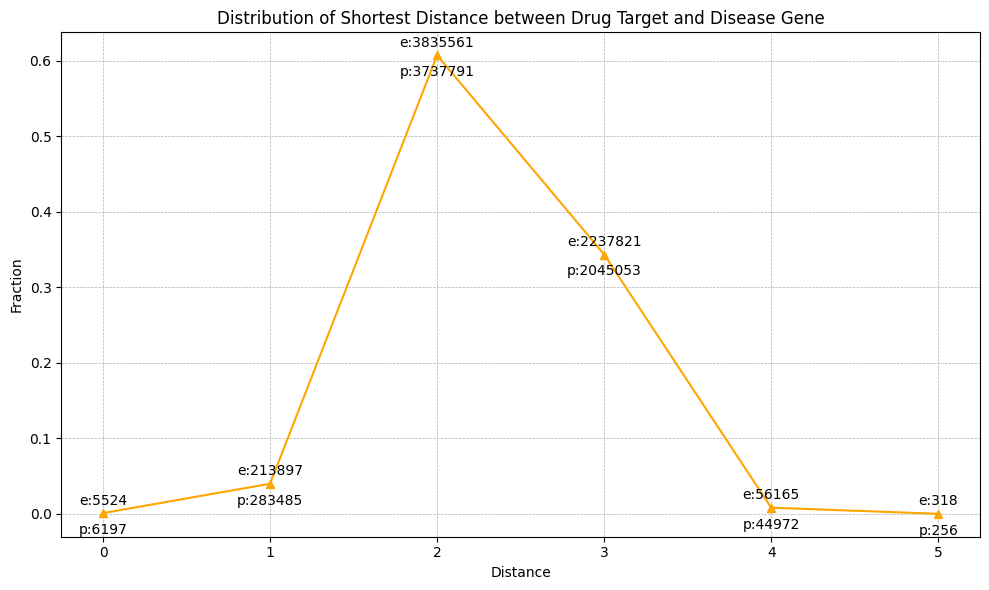

In [ ]:
# Count occurrence for each path length
path_counts = df_all_shortest_paths['Path Length'].value_counts()

# Calculate the fraction for each path length
total_paths = len(df_all_shortest_paths)
fractions = path_counts / total_paths
fractions = fractions.sort_index()


# Initialize the dictionaries
etiological_counts = defaultdict(int)
palliative_counts = defaultdict(int)

# Calculate the counts for each path length and MoA category
moa_counts = df_all.groupby(['Path Length', 'MoA']).size().unstack(fill_value=0)

# Since 'MoA' contains 0 for etiological and 1 for palliative, we can directly extract the counts
etiological_counts = moa_counts.get(0, pd.Series()).to_dict()
palliative_counts = moa_counts.get(1, pd.Series()).to_dict()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fractions.index, fractions.values, marker='^', label='Disease genes versus drug targets', color='orange', linestyle='-')

# Annotating each point with etiological and palliative
for distance in fractions.index:
    etiological_count = etiological_counts.get(distance, 0)
    palliative_count = palliative_counts.get(distance, 0)

    # Adjust the y_offset to your preference for text placement
    y_offset = 0.0001

    plt.annotate(f'e:{etiological_count}', (distance, fractions[distance] + y_offset), textcoords="offset points", xytext=(0,6), ha='center', fontsize=10)
    plt.annotate(f'p:{palliative_count}', (distance, fractions[distance] - y_offset), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=10)

plt.xlabel('Distance')
plt.xlabel('Distance')
plt.ylabel('Fraction')
plt.title('Distribution of Shortest Distance between Drug Target and Disease Gene')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Yildrim_all_shortest_distance.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()


### 2. **All vs. All (Unique) Method:** Computes the shortest distance from each drug to every disease, counting each drug only once for each unique path length.

<ipython-input-68-235631ef041e>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  etiological_counts = moa_counts.get(0, pd.Series()).to_dict()
<ipython-input-68-235631ef041e>:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  palliative_counts = moa_counts.get(1, pd.Series()).to_dict()


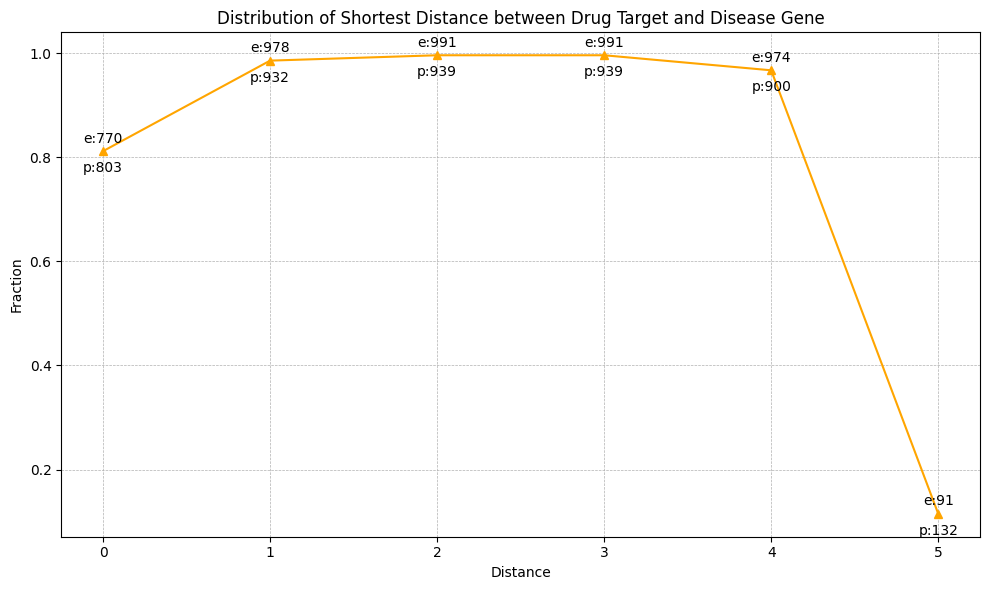

In [ ]:
# Drop duplicates to ensure that each drug is only counted once per distance
df_unique_per_distance = df_all_shortest_paths.drop_duplicates(subset=['Drug', 'Path Length'])

# Count unique occurrences for each path length
unique_path_counts = df_unique_per_distance['Path Length'].value_counts()

# Calculate the fraction for each path length based on unique drug counts
total_unique_drugs = df_unique_per_distance['Drug'].nunique()
unique_fractions = unique_path_counts / total_unique_drugs
unique_fractions = unique_fractions.sort_index()

# Now use unique_fractions for plotting
# Initialize the dictionaries
etiological_counts = defaultdict(int)
palliative_counts = defaultdict(int)

# Calculate the counts for each path length and MoA category
moa_counts = df_unique_per_distance.groupby(['Path Length', 'MoA']).size().unstack(fill_value=0)

# Since 'MoA' contains 0 for etiological and 1 for palliative, we can directly extract the counts
etiological_counts = moa_counts.get(0, pd.Series()).to_dict()
palliative_counts = moa_counts.get(1, pd.Series()).to_dict()


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fractions.index, unique_fractions.values, marker='^', label='Disease genes versus drug targets', color='orange', linestyle='-')

# Annotating each point with etiological and palliative
for distance in unique_fractions.index:
    etiological_count = etiological_counts.get(distance, 0)
    palliative_count = palliative_counts.get(distance, 0)

    # Adjust the y_offset to your preference for text placement
    y_offset = 0.0001

    plt.annotate(f'e:{etiological_count}', (distance, unique_fractions[distance] + y_offset), textcoords="offset points", xytext=(0,6), ha='center', fontsize=10)
    plt.annotate(f'p:{palliative_count}', (distance, unique_fractions[distance] - y_offset), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=10)

plt.xlabel('Distance')
plt.xlabel('Distance')
plt.ylabel('Fraction')
plt.title('Distribution of Shortest Distance between Drug Target and Disease Gene')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Yildrim_ALL_unique_drug_count_shortest_distance.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()


### 3. **Unique Minimum Shortest Distance Method:** For each drug, we determined its shortest distance to a disease. If one drug had the same shortest distance for several diseases, we eliminated the duplicate values, retaining only one unique shortest distance for each drug.

In [ ]:
df_unique_shortest_paths = pd.read_csv('Unique_shortest_paths_compress.csv.gz', compression='gzip')

<ipython-input-73-23b6b2d17a4e>:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  etiological_counts = moa_counts.get(0, pd.Series()).to_dict()
<ipython-input-73-23b6b2d17a4e>:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  palliative_counts = moa_counts.get(1, pd.Series()).to_dict()


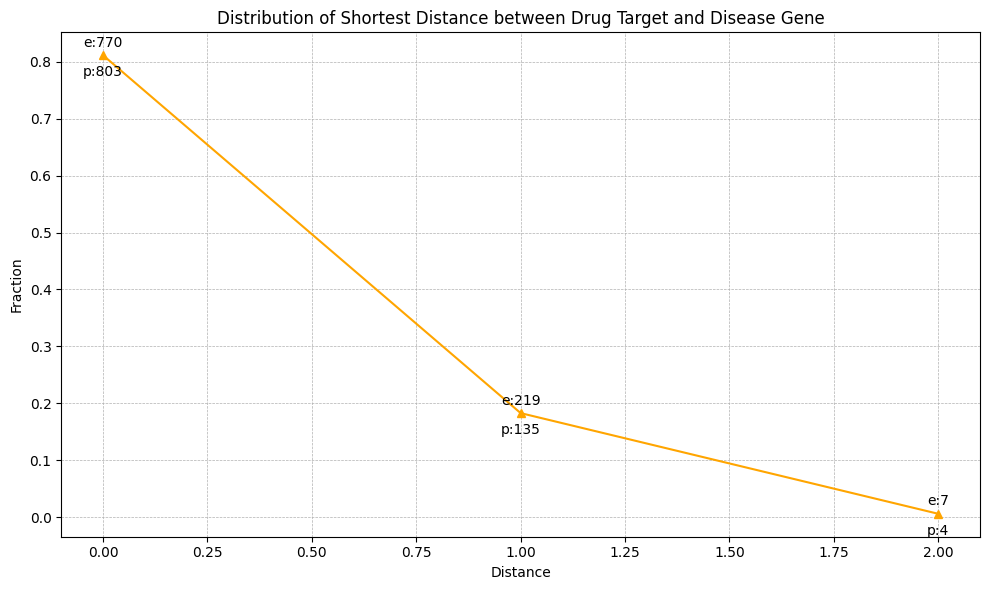

In [ ]:
df_unique_shortest_paths = df_unique_shortest_paths.drop_duplicates(subset=['Drug', 'Path Length'])

# Count occurrence for each path length
path_counts = df_unique_shortest_paths['Path Length'].value_counts()

# Calculate the fraction for each path length
total_paths = len(df_unique_shortest_paths)
fractions = path_counts / total_paths
fractions = fractions.sort_index()

# Initialize the dictionaries
etiological_counts = defaultdict(int)
palliative_counts = defaultdict(int)

# Calculate the counts for each path length and MoA category
moa_counts = df_unique_shortest_paths.groupby(['Path Length', 'MoA']).size().unstack(fill_value=0)

# Since 'MoA' contains 0 for etiological and 1 for palliative, we can directly extract the counts
etiological_counts = moa_counts.get(0, pd.Series()).to_dict()
palliative_counts = moa_counts.get(1, pd.Series()).to_dict()


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fractions.index, fractions.values, marker='^', label='Disease genes versus drug targets', color='orange', linestyle='-')

# Annotating each point with etiological, palliative, and baseline counts
for distance in fractions.index:
    etiological_count = etiological_counts.get(distance, 0)
    palliative_count = palliative_counts.get(distance, 0)

    # Adjust the y_offset to your preference for text placement
    y_offset = 0.0001

    plt.annotate(f'e:{etiological_count}', (distance, fractions[distance] + y_offset), textcoords="offset points", xytext=(0,6), ha='center', fontsize=10)
    plt.annotate(f'p:{palliative_count}', (distance, fractions[distance] - y_offset), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=10)

plt.xlabel('Distance')
plt.ylabel('Fraction')
plt.title('Distribution of Shortest Distance between Drug Target and Disease Gene')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Yildrim_unique_minimum_shortest_distance.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()
